In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 673 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


#Import libary

In [ ]:
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.neural_network import MLPRegressor
import datetime
from datetime import datetime
from datetime import timedelta
import time
from sklearn import metrics
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.svm import SVR
from sklearn.neighbors import RadiusNeighborsRegressor

#Load data - Verify data

In [ ]:
yf.pdr_override()
start_date_NA = '01-01-2004'
end_date_NA = '01-01-2022'

start = datetime.strptime(start_date_NA, '%d-%m-%Y')
end = datetime.strptime(end_date_NA, '%d-%m-%Y')
df_nflx = pdr.get_data_yahoo('NFLX', data_source='yahoo', start=start, end=end)


[*********************100%***********************]  1 of 1 completed


In [ ]:
df_nflx.round(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,4.11,4.13,3.84,3.92,3.92,50230600
2004-01-05,3.89,4.06,3.88,3.99,3.99,25207000
2004-01-06,3.95,4.34,3.94,4.26,4.26,52633000
2004-01-07,4.31,4.47,4.25,4.45,4.45,68432000
2004-01-08,4.54,4.56,4.29,4.43,4.43,37178400
...,...,...,...,...,...,...
2021-12-27,615.00,615.00,609.25,613.12,613.12,2061500
2021-12-28,614.95,618.41,609.69,610.71,610.71,1882800
2021-12-29,610.71,613.98,604.68,610.54,610.54,1287200


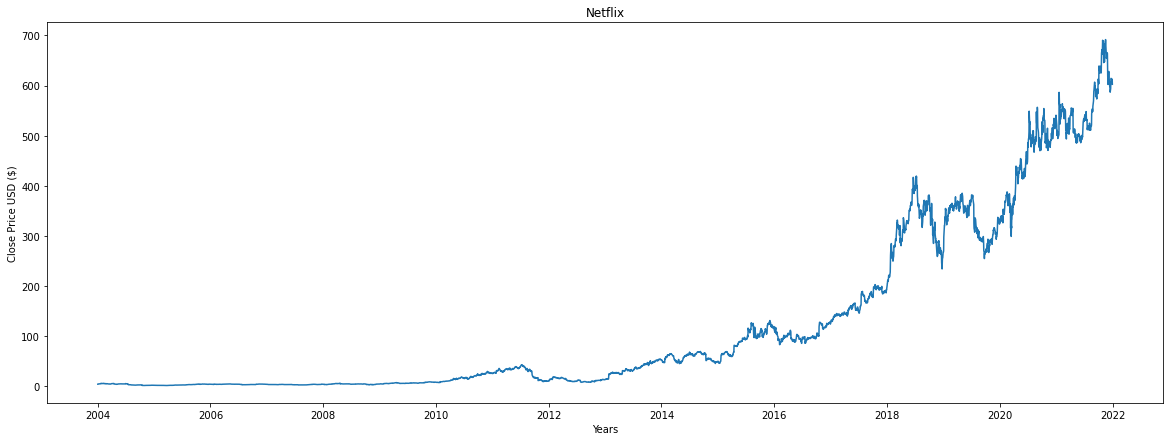

In [ ]:
data = df_nflx.filter(['Close'])
plt.figure(figsize=(20,7))
plt.title('Netflix')
plt.xlabel('Years')
plt.ylabel('Close Price USD ($)')
plt.plot(data)
plt.show()

In [ ]:
#Verify any possible missing data and use the average price to fill it.
print("NLFX")
print(df_nflx.isnull().sum())
print(df_nflx.describe())

NLFX
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
              Open         High          Low        Close    Adj Close  \
count  4532.000000  4532.000000  4532.000000  4532.000000  4532.000000   
mean    121.439001   123.254035   119.555202   121.464618   121.464618   
std     170.193751   172.584869   167.673445   170.184198   170.184198   
min       1.300000     1.317143     1.272857     1.290000     1.290000   
25%       4.511786     4.599643     4.380000     4.494286     4.494286   
50%      32.162857    32.743572    31.489285    32.172142    32.172142   
75%     163.037502   163.947495   160.597504   162.569996   162.569996   
max     692.349976   700.989990   686.090027   691.690002   691.690002   

             Volume  
count  4.532000e+03  
mean   1.702338e+07  
std    1.962073e+07  
min    1.144000e+06  
25%    6.440425e+06  
50%    1.090180e+07  
75%    2.037032e+07  
max    3.234140e+08  


Ta thấy giá cổ phiếu trong ngày được xác định bằng với mức giá lúc đóng cửa (Close), vậy nên chúng ta sẽ tập trung xây dựng mô hình dựa trên dữ liệu Close. Do đó sẽ tạo một dataframe mới chỉ chứa cột “Close”


In [ ]:
close_prices_nflx = df_nflx.loc[:,'Close'].values

#Scaling

In [ ]:
scaler1 = MinMaxScaler()
data_scaled_nflx = scaler1.fit_transform(close_prices_nflx.reshape(-1,1))

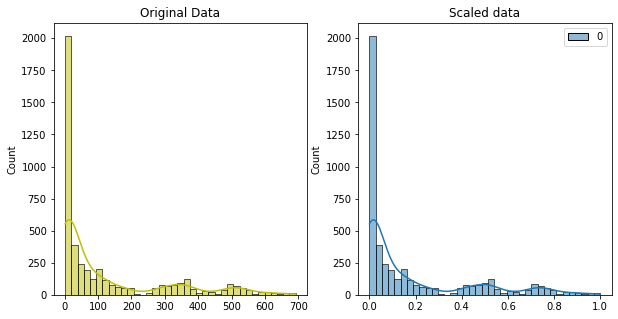

In [ ]:
# #Visualize the close price data
# plot both together to compare
fig, ax=plt.subplots(1,2 ,figsize=(10, 5))
sns.histplot(close_prices_nflx, ax=ax[0], color='y',kde=True)
ax[0].set_title("Original Data")
sns.histplot(data_scaled_nflx, ax=ax[1], color='y',kde=True)
ax[1].set_title("Scaled data")
plt.show()


#Create Data Train

In [ ]:
def create_data(dataset, predict_days):
    X, Y = [], []
    for i in range(predict_days,len(dataset)):
      X.append(dataset[i-predict_days:i,0])
      Y.append(dataset[i,0])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [ ]:
predict_days = 60
X_train_nflx, y_train_nflx = create_data(data_scaled_nflx, predict_days)

#Train - Create Data Test to...



Giả sử ta đã train với bộ dữ liệu từ ngày '01-01-2004' đến '01-01-2022'
Đoạn code tiếp theo, ta sẽ thực hiện dự đoán giá cổ phiếu trong vòng 14 ngày tiếp theo của nó

**chú ý**:
  - Ví dụ start_date = '01-01-2022', end_date = '17-01-2022' nghĩa là dòng đầu sẽ là  giá của ngày 02-01-2022 và dòng cuối là giá của 16-01-2022.

# Recurrent Neural Network(RNN)

In [ ]:
start = time.time()
# Initialising the RNN
regressor = Sequential()
# Add the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True, input_shape = (X_train_nflx.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# Third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

# Fitting the RNN to the training set
regressor.fit(X_train_nflx, y_train_nflx, epochs = 50, batch_size = 32)
end = time.time()
time_train_RNN_nflx = end - start

Epoch 1/50
140/140 [==============================] - 18s 89ms/step - loss: 0.0137
Epoch 2/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0037
Epoch 3/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0025
Epoch 4/50
140/140 [==============================] - 8s 59ms/step - loss: 0.0022
Epoch 5/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0020
Epoch 6/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0019
Epoch 7/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0018
Epoch 8/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0015
Epoch 9/50
140/140 [==============================] - 10s 68ms/step - loss: 0.0014
Epoch 10/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0014
Epoch 11/50
140/140 [==============================] - 8s 59ms/step - loss: 0.0013
Epoch 12/50
140/140 [==============================] - 8s 58ms/step - loss: 0.0013
Epoch 13/50

#Multilayer Perceptron

In [ ]:
#regression model NFLX
start_time = time.time()
mlp_nflx = MLPRegressor(random_state=1,max_iter=1000,activation = 'relu',
                       solver = 'adam')
#fit model
mlp_nflx.fit(X_train_nflx,y_train_nflx)
end_time = time.time()
time_train_MLP_nflx = -start_time + end_time

#LSTM

In [ ]:
#Build the LSTM Model
start = time.time()
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_nflx.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train_nflx,y_train_nflx, epochs = 100, batch_size = 32)
end = time.time()
time_lstm = end - start

Epoch 1/100
140/140 [==============================] - 25s 125ms/step - loss: 0.0048
Epoch 2/100
140/140 [==============================] - 17s 124ms/step - loss: 0.0014
Epoch 3/100
140/140 [==============================] - 17s 124ms/step - loss: 0.0017
Epoch 4/100
140/140 [==============================] - 17s 124ms/step - loss: 0.0011
Epoch 5/100
140/140 [==============================] - 18s 131ms/step - loss: 0.0012
Epoch 6/100
140/140 [==============================] - 19s 138ms/step - loss: 0.0011
Epoch 7/100
140/140 [==============================] - 17s 124ms/step - loss: 0.0011
Epoch 8/100
140/140 [==============================] - 20s 142ms/step - loss: 0.0011
Epoch 9/100
140/140 [==============================] - 17s 125ms/step - loss: 0.0010
Epoch 10/100
140/140 [==============================] - 17s 124ms/step - loss: 0.0011
Epoch 11/100
140/140 [==============================] - 18s 125ms/step - loss: 9.9492e-04
Epoch 12/100
140/140 [==============================] - 17s

#Radius neighbors regressor

In [ ]:
from sklearn.neighbors import RadiusNeighborsRegressor
start_time = time.time()
neigh_nflx = RadiusNeighborsRegressor(radius=1.5)
neigh_nflx.fit(X_train_nflx, y_train_nflx)
end_time = time.time()
time_train_radius_nflx = -start_time + end_time

#Random Forest

In [ ]:

start_time = time.time()
regr_nflx = RandomForestRegressor(max_depth=4, max_leaf_nodes=13, random_state=0)
regr_nflx.fit(X_train_nflx, y_train_nflx)
end_time = time.time()
time_train_rf_nflx = -start_time + end_time

#Time to train

In [ ]:
print('MLP: ', time_train_MLP_nflx )
print('RNN: ',time_train_RNN_nflx)
print('Radius neighbors regressor: ', time_train_radius_nflx )
print('Random Forest: ', time_train_rf_nflx  )
print("LSTM: ", time_train_lstm_nflx)

MLP:  0.4884612560272217
RNN:  448.8359417915344
Radius neighbors regressor:  0.00810098648071289
Random Forest:  9.488799095153809
LSTM:  1529.3503603935242


#**Predict close prices of the 14 next days**

In [ ]:
#Load the test data
def load_test(start_date, end_date, company_name):
  yf.pdr_override()
  start = datetime.strptime(start_date, '%d-%m-%Y')
  end = datetime.strptime(end_date, '%d-%m-%Y')
  test_data = pdr.get_data_yahoo(company_name, data_source='yahoo', start=start, end=end)
  return test_data['Close']

In [ ]:
#Load the test data
start_date_14d = '01-01-2022'
end_date_14d = '17-01-2022'
#Stocks are only traded on weekdays except Saturdays, Sundays and public holidays
test_data_14d_nflx = load_test(start_date_14d, end_date_14d, 'NFLX')

[*********************100%***********************]  1 of 1 completed


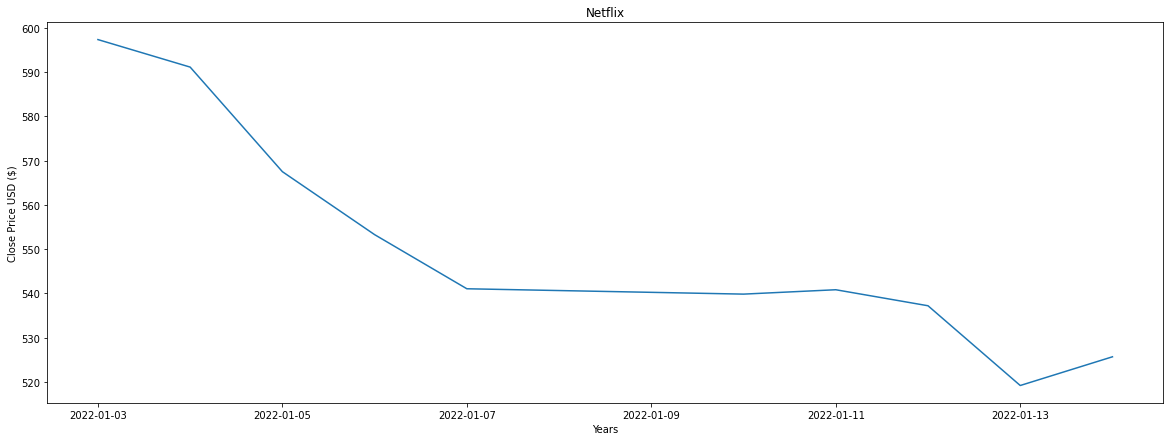

In [ ]:
#Visualize the test data
#Visualize the close price data
data = df_nflx.filter(['Close'])
plt.figure(figsize=(20,7))
plt.title('Netflix')
plt.xlabel('Years')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data_14d_nflx)
plt.show()

##Get data predict to predict close prices of the next day



In [ ]:
def predict_the_next_n_day(start_date, end_date, X_train, y_train, x_test, model_name):
  diff, next_day, day = find_day_and_start_day_predict(start_date, end_date)
  prices =[]
  for x in range(0, diff-1):
    if(day == "Sunday" or day == "Saturday" ):
      print(next_day,"is",day)
      next_day = datetime.strptime(next_day, "%d-%m-%Y") + timedelta(days=1)
      next_day = next_day.strftime("%d-%m-%Y")
      day = datetime.strptime(next_day, "%d-%m-%Y").strftime("%A")
    elif(next_day == "17-01-2022"):
      print(next_day,"is holiday")
      next_day = datetime.strptime(next_day, "%d-%m-%Y") + timedelta(days=1)
      next_day = next_day.strftime("%d-%m-%Y")
      day = datetime.strptime(next_day, "%d-%m-%Y").strftime("%A")
    else:
      predicted_prices = model_name.predict(x_test)
      prices.append(predicted_prices[0])
      print("Predict day",x+1,":DONE")
      x_test = np.append(x_test, predicted_prices[0])
      x_test = x_test[len(x_test) - predict_days:].reshape(1,-1)
      #print(x_test)
      next_day = datetime.strptime(next_day, "%d-%m-%Y") + timedelta(days=1)
      next_day = next_day.strftime("%d-%m-%Y")
      day = datetime.strptime(next_day, "%d-%m-%Y").strftime("%A")
  return prices

In [ ]:
def find_day_and_start_day_predict(start_date, end_date ):
  diff = datetime.strptime((end_date), "%d-%m-%Y") - datetime.strptime((start_date), "%d-%m-%Y")
  next_day = datetime.strptime(start_date, "%d-%m-%Y") + timedelta(days=1)
  next_day = next_day.strftime("%d-%m-%Y")
  day = datetime.strptime(next_day, "%d-%m-%Y").strftime("%A")
  return diff.days, next_day, day

In [ ]:
inputs_nflx = df_nflx['Close'][df_nflx['Close'].shape[0] - predict_days:].values.reshape(-1,1)
inputs_nflx= scaler1.transform(inputs_nflx)
#Prediction on test data
x_test_nflx_14 = np.array(inputs_nflx).reshape(1,-1)
print(x_test_nflx_14.shape)

(1, 60)


####Recurrent Neural Network(RNN)

In [ ]:
print("start date",start_date_14d)
print("end date",end_date_14d)
start_time = time.time()
prices_nflx_rnn = predict_the_next_n_day(start_date_14d, end_date_14d, X_train_nflx, y_train_nflx, x_test_nflx_14,regressor)
end_time = time.time()
time_predicted_rnn_14day_nflx = -start_time + end_time

start date 01-01-2022
end date 17-01-2022
02-01-2022 is Sunday
1/1 [==============================] - 0s 26ms/step
Predict day 2 :DONE
1/1 [==============================] - 0s 26ms/step
Predict day 3 :DONE
1/1 [==============================] - 0s 24ms/step
Predict day 4 :DONE
1/1 [==============================] - 0s 26ms/step
Predict day 5 :DONE
1/1 [==============================] - 0s 26ms/step
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
1/1 [==============================] - 0s 30ms/step
Predict day 9 :DONE
1/1 [==============================] - 0s 30ms/step
Predict day 10 :DONE
1/1 [==============================] - 0s 29ms/step
Predict day 11 :DONE
1/1 [==============================] - 0s 25ms/step
Predict day 12 :DONE
1/1 [==============================] - 0s 27ms/step
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday


In [ ]:
prices_nflx_rnn = np.array(prices_nflx_rnn)
predicted_prices_nflx_rnn = scaler1.inverse_transform(prices_nflx_rnn.reshape(-1,1))

In [ ]:
predicted_prices_nflx_rnn= predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])
actual_prices_nflx = test_data_14d_nflx
df_temp_nflx_rnn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rnn})
print(df_temp_nflx_rnn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  498.739441
2022-01-04  591.150024  485.607483
2022-01-05  567.520020  466.802032
2022-01-06  553.289978  444.399780
2022-01-07  541.059998  423.057037
2022-01-10  539.849976  403.824188
2022-01-11  540.840027  386.315338
2022-01-12  537.219971  369.790375
2022-01-13  519.200012  352.083221
2022-01-14  525.690002  335.577850


#####Mean absolute error

In [ ]:
MAE_rnn = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_rnn)
print('Mean Absolute Error:', MAE_rnn)

Mean Absolute Error: 134.69932556152344


####MLP

In [ ]:
print("start date",start_date_14d)
print("end date",end_date_14d)
start_time = time.time()
prices_nflx_mlp = predict_the_next_n_day(start_date_14d, end_date_14d, X_train_nflx, y_train_nflx, x_test_nflx_14, mlp_nflx)
end_time = time.time()
time_predicted_MLP_14day_nflx = -start_time + end_time

start date 01-01-2022
end date 17-01-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday


In [ ]:
prices_nflx_mlp = np.array(prices_nflx_mlp)
predicted_prices_nflx_mlp = scaler1.inverse_transform(prices_nflx_mlp.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_mlp= predicted_prices_nflx_mlp.reshape([(predicted_prices_nflx_mlp.shape[0])])
df_temp_nflx_mlp = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_mlp})
print(df_temp_nflx_mlp)

                Actual   Predicted
Date                              
2022-01-03  597.369995  595.124482
2022-01-04  591.150024  598.534216
2022-01-05  567.520020  597.980784
2022-01-06  553.289978  598.478645
2022-01-07  541.059998  597.884528
2022-01-10  539.849976  588.764517
2022-01-11  540.840027  602.674450
2022-01-12  537.219971  610.144654
2022-01-13  519.200012  609.315065
2022-01-14  525.690002  610.821354


#####Mean absolute error

In [ ]:
MAE_MLP = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_mlp)
print('Mean Absolute Error:', MAE_MLP)

Mean Absolute Error: 50.10237186339125


####Radius neighbors regressor

In [ ]:
print("start date",start_date_14d)
print("end date",end_date_14d)
start_time = time.time()
prices_nflx_knn = predict_the_next_n_day(start_date_14d, end_date_14d, X_train_nflx, y_train_nflx, x_test_nflx_14, neigh_nflx)
end_time = time.time()
time_predicted_radius_14day_nflx = -start_time + end_time

start date 01-01-2022
end date 17-01-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday


In [ ]:
prices_nflx_knn = np.array(prices_nflx_knn)
predicted_prices_nflx_knn = scaler1.inverse_transform(prices_nflx_knn.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_knn = predicted_prices_nflx_knn.reshape([(predicted_prices_nflx_knn.shape[0])])
df_temp_nflx_knn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_knn})
print(df_temp_nflx_knn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  567.318865
2022-01-04  591.150024  566.259847
2022-01-05  567.520020  565.662573
2022-01-06  553.289978  565.193950
2022-01-07  541.059998  564.890240
2022-01-10  539.849976  564.467904
2022-01-11  540.840027  563.954600
2022-01-12  537.219971  563.233132
2022-01-13  519.200012  560.318716
2022-01-14  525.690002  559.363469


#####Mean absolute error

In [ ]:
MAE_radius = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_knn)
print('Mean Absolute Error:', MAE_radius)


Mean Absolute Error: 24.107080226920935


####Random Forest

In [ ]:
print("start date",start_date_14d)
print("end date",end_date_14d)
start_time = time.time()
prices_nflx_rf = predict_the_next_n_day(start_date_14d, end_date_14d, X_train_nflx, y_train_nflx, x_test_nflx_14, regr_nflx)
end_time = time.time()
time_predicted_rf_14day_nflx = -start_time + end_time

start date 01-01-2022
end date 17-01-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday


In [ ]:
prices_nflx_rf = np.array(prices_nflx_rf)
predicted_prices_nflx_rf = scaler1.inverse_transform(prices_nflx_rf.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_rf = predicted_prices_nflx_rf.reshape([(predicted_prices_nflx_rf.shape[0])])
df_temp_nflx_rf = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rf})
print(df_temp_nflx_rf)

                Actual   Predicted
Date                              
2022-01-03  597.369995  615.752611
2022-01-04  591.150024  615.752611
2022-01-05  567.520020  615.752611
2022-01-06  553.289978  615.752611
2022-01-07  541.059998  615.752611
2022-01-10  539.849976  615.752611
2022-01-11  540.840027  615.752611
2022-01-12  537.219971  615.752611
2022-01-13  519.200012  615.752611
2022-01-14  525.690002  615.752611


#####Mean absolute error

In [ ]:
MAE_rf = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_rf)
print('Mean Absolute Error:', MAE_rf)

Mean Absolute Error: 64.43361101028529


####Long Short Term Memory

In [ ]:
print("start date",start_date_14d)
print("end date",end_date_14d)
start_time = time.time()
prices_nflx_lstm = predict_the_next_n_day(start_date_14d, end_date_14d, X_train_nflx, y_train_nflx, x_test_nflx_14, model)
end_time = time.time()
time_predicted_lstm_14day_nflx = -start_time + end_time

start date 01-01-2022
end date 17-01-2022
02-01-2022 is Sunday
1/1 [==============================] - 0s 48ms/step
Predict day 2 :DONE
1/1 [==============================] - 0s 41ms/step
Predict day 3 :DONE
1/1 [==============================] - 0s 49ms/step
Predict day 4 :DONE
1/1 [==============================] - 0s 49ms/step
Predict day 5 :DONE
1/1 [==============================] - 0s 46ms/step
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
1/1 [==============================] - 0s 49ms/step
Predict day 9 :DONE
1/1 [==============================] - 0s 59ms/step
Predict day 10 :DONE
1/1 [==============================] - 0s 73ms/step
Predict day 11 :DONE
1/1 [==============================] - 0s 54ms/step
Predict day 12 :DONE
1/1 [==============================] - 0s 43ms/step
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday


In [ ]:
prices_nflx_lstm = np.array(prices_nflx_lstm)
predicted_prices_nflx_lstm = scaler1.inverse_transform(prices_nflx_lstm.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_lstm = predicted_prices_nflx_lstm.reshape([(predicted_prices_nflx_lstm.shape[0])])
df_temp_nflx_lstm = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_lstm})
print(df_temp_nflx_lstm)

                Actual   Predicted
Date                              
2022-01-03  597.369995  616.875183
2022-01-04  591.150024  618.984802
2022-01-05  567.520020  621.407776
2022-01-06  553.289978  623.529663
2022-01-07  541.059998  625.485596
2022-01-10  539.849976  627.493042
2022-01-11  540.840027  629.621948
2022-01-12  537.219971  631.764099
2022-01-13  519.200012  633.854065
2022-01-14  525.690002  635.871460


#####Mean absolute error

In [ ]:
MAE_lstm= metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_lstm)
print('Mean Absolute Error:', MAE_lstm)

Mean Absolute Error: 75.16976318359374


###Visualize real prices and predicted prices

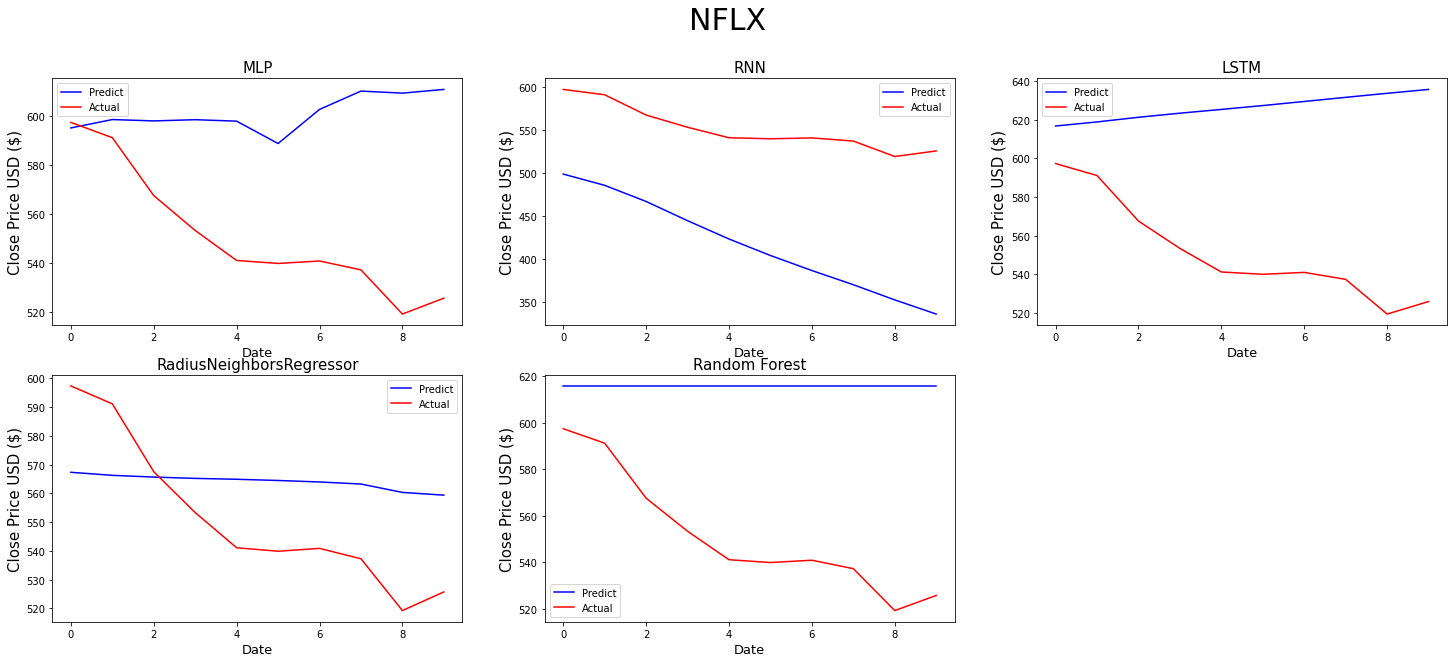

In [ ]:
#Visualize the test data
#Visualize the close price data
fg, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[1][2].set_visible(False)
fg.suptitle('NFLX\n', fontsize = 30)


ax[0,0].set_title('MLP', fontsize=15)
ax[0,1].set_title('RNN', fontsize=15)
ax[1,0].set_title('RadiusNeighborsRegressor',fontsize=15)
ax[1,1].set_title('Random Forest', fontsize=15)
ax[0,2].set_title('LSTM', fontsize=15)


ax[0,0].set_xlabel('Date', fontsize=13)
ax[0,1].set_xlabel('Date', fontsize=13)
ax[1,0].set_xlabel('Date', fontsize=13)
ax[1,1].set_xlabel('Date', fontsize=13)
ax[0,2].set_xlabel('Date', fontsize=13)



ax[0,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,2].set_ylabel('Close Price USD ($)', fontsize=15)


ax[0,0].plot(df_temp_nflx_mlp['Predicted'].values, color="blue")
ax[0,0].plot(df_temp_nflx_mlp['Actual'].values, color="red")
ax[0,0].legend(['Predict', 'Actual'])

ax[0,1].plot(df_temp_nflx_rnn['Predicted'].values, color="blue")
ax[0,1].plot(df_temp_nflx_rnn['Actual'].values, color="red")
ax[0,1].legend(['Predict', 'Actual'])

ax[1,0].plot(df_temp_nflx_knn['Predicted'].values, color="blue")
ax[1,0].plot(df_temp_nflx_knn['Actual'].values, color="red")
ax[1,0].legend(['Predict', 'Actual'])

ax[1,1].plot(df_temp_nflx_rf['Predicted'].values, color="blue")
ax[1,1].plot(df_temp_nflx_rf['Actual'].values, color="red")
ax[1,1].legend(['Predict', 'Actual'])

ax[0,2].plot(df_temp_nflx_lstm['Predicted'].values, color="blue")
ax[0,2].plot(df_temp_nflx_lstm['Actual'].values, color="red")
ax[0,2].legend(['Predict', 'Actual'])

###Time to predict

In [ ]:
print('MLP: ',time_predicted_MLP_14day_nflx)
print('RNN: ',time_predicted_rnn_14day_nflx )
print('Radius neighbors regressor: ', time_predicted_radius_14day_nflx )
print('Random Forest: ', time_predicted_rf_14day_nflx)

MLP:  0.007900714874267578
RNN:  1.372403621673584
Radius neighbors regressor:  0.06271958351135254
Random Forest:  0.215972900390625


###Visualize MAE

In [ ]:
mae = [MAE_MLP, MAE_rnn, MAE_radius, MAE_rf, MAE_lstm]
names = ['MLP', 'RNN', 'Radius', 'Random Forest', 'LSTM']

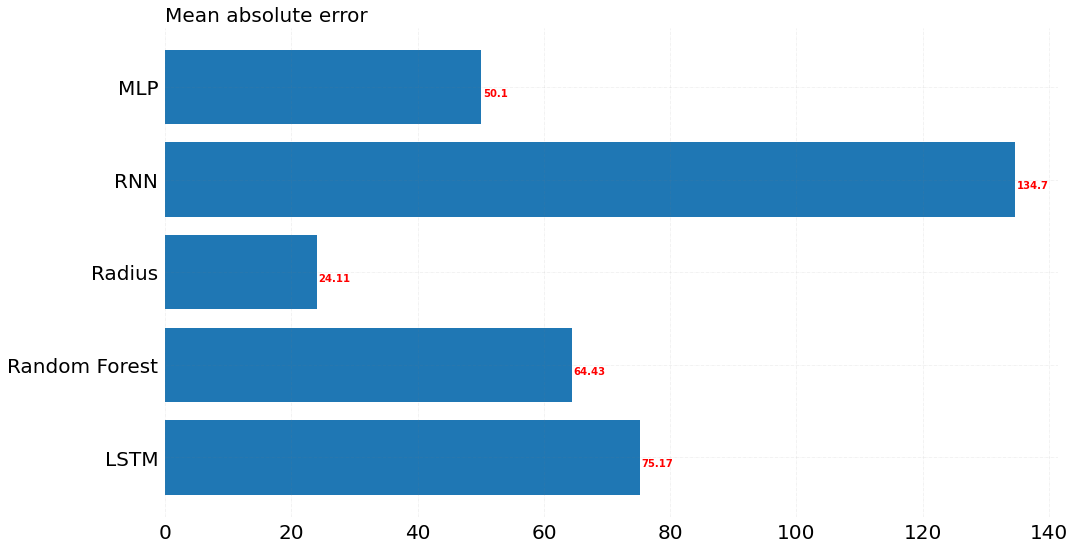

In [ ]:
# Figure Size
values = mae
fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(names, values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.tick_params(axis='both', which='major', labelsize=20)


# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='red')
# Add Plot Title
ax.set_title('Mean absolute error ',
             loc ='left',fontsize = '20' )
# Show Plot
plt.show()

##Get the real data to predict close prices of the next day

In [ ]:
inputs_nflx = df_nflx['Close'][df_nflx['Close'].shape[0] - predict_days:].values.reshape(-1,1)
inputs_nflx= scaler1.transform(inputs_nflx)
#Prediction on test data
x_test_nflx_14 = np.array(inputs_nflx).reshape(1,-1)
print(x_test_nflx_14.shape)

(1, 60)


In [ ]:
total_dataset_nflx = pd.concat((df_nflx['Close'],test_data_14d_nflx), axis = 0)
inputs_nflx_14d = total_dataset_nflx[len(total_dataset_nflx) - len(test_data_14d_nflx) - 60:].values.reshape(-1,1)
inputs_nflx_14d = scaler1.transform(inputs_nflx_14d)

#Prediction on test data
x_test_nflx_14d = []
for x in range(60, len(inputs_nflx_14d)):
  x_test_nflx_14d.append(inputs_nflx_14d[x-60:x, 0])
x_test_nflx_14d = np.array(x_test_nflx_14d)
print(x_test_nflx_14d.shape)
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


(10, 60)


####Recurrent Neural Network(RNN)

In [ ]:
start = time.time()
predicted_prices_nflx_rnn = regressor.predict(x_test_nflx_14d).reshape(-1,1)
end = time.time()
time_rnn = end - start
predicted_prices_nflx_rnn = scaler1.inverse_transform(predicted_prices_nflx_rnn)

1/1 [==============================] - 0s 29ms/step


In [ ]:
actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_rnn= predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])
df_temp_nflx_rnn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rnn})
print(df_temp_nflx_rnn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  498.739380
2022-01-04  591.150024  496.749542
2022-01-05  567.520020  493.847870
2022-01-06  553.289978  487.788391
2022-01-07  541.059998  479.392151
2022-01-10  539.849976  469.978485
2022-01-11  540.840027  461.845367
2022-01-12  537.219971  455.817230
2022-01-13  519.200012  451.344360
2022-01-14  525.690002  445.759125


#####Mean absolute errorean squared Error

In [ ]:
MAE_rnn = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_rnn)
print('Mean Absolute Error:', MAE_rnn)

Mean Absolute Error: 77.19281005859375


####MLP

In [ ]:
start = time.time()
predicted_prices_nflx_mlp = mlp_nflx.predict(x_test_nflx_14d).reshape(-1,1)
end = time.time()
time_mlp = end - start
predicted_prices_nflx_mlp = scaler1.inverse_transform(predicted_prices_nflx_mlp)

In [ ]:

actual_prices_nflx = test_data_14d_nflx
predicted_prices_nflx_mlp= predicted_prices_nflx_mlp.reshape([(predicted_prices_nflx_mlp.shape[0])])
df_temp_nflx_mlp = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_mlp})
print(df_temp_nflx_mlp)

                Actual   Predicted
Date                              
2022-01-03  597.369995  595.124482
2022-01-04  591.150024  599.163373
2022-01-05  567.520020  596.461985
2022-01-06  553.289978  588.298830
2022-01-07  541.059998  580.239003
2022-01-10  539.849976  561.677101
2022-01-11  540.840027  568.982360
2022-01-12  537.219971  571.695698
2022-01-13  519.200012  565.636060
2022-01-14  525.690002  566.778001


#####Mean absolute error

In [ ]:
MAE_MLP = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_mlp)
print('Mean Absolute Error:', MAE_MLP)

Mean Absolute Error: 28.535791575325835


####Radius neighbors regressor

In [ ]:
start = time.time()
predicted_prices_nflx_knn = neigh_nflx.predict(x_test_nflx_14d).reshape(-1,1)
end = time.time()
time_radius = end - start
predicted_prices_nflx_knn = scaler1.inverse_transform(predicted_prices_nflx_knn)
predicted_prices_nflx_knn = predicted_prices_nflx_knn.reshape(10)

In [ ]:
df_temp_nflx_knn= pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_knn})
print(df_temp_nflx_knn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  567.318865
2022-01-04  591.150024  566.741938
2022-01-05  567.520020  565.897749
2022-01-06  553.289978  565.478078
2022-01-07  541.059998  565.040290
2022-01-10  539.849976  564.587606
2022-01-11  540.840027  563.954600
2022-01-12  537.219971  563.233132
2022-01-13  519.200012  560.466694
2022-01-14  525.690002  558.217305


#####Mean absolute error

In [ ]:
MAE_radius = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_knn)
print('Mean Absolute Error:', MAE_radius)

Mean Absolute Error: 23.990922892221977


####Random Forest

In [ ]:
start = time.time()
predicted_prices_nflx_rf = regr_nflx.predict(x_test_nflx_14d).reshape(-1,1)
end = time.time()
time_rf = end - start
predicted_prices_nflx_rf = scaler1.inverse_transform(predicted_prices_nflx_rf)
predicted_prices_nflx_rf = predicted_prices_nflx_rf.reshape(10)

In [ ]:
df_temp_nflx_rf= pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rf})
print(df_temp_nflx_rf)

                Actual   Predicted
Date                              
2022-01-03  597.369995  615.752611
2022-01-04  591.150024  615.752611
2022-01-05  567.520020  615.752611
2022-01-06  553.289978  583.073053
2022-01-07  541.059998  537.375017
2022-01-10  539.849976  531.698796
2022-01-11  540.840027  531.698796
2022-01-12  537.219971  531.698796
2022-01-13  519.200012  531.698796
2022-01-14  525.690002  529.651984


#####Mean absolute error

In [ ]:
MAE_rf = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_rf)
print('Mean Absolute Error:', MAE_rf)

Mean Absolute Error: 16.396020046917613


####Long Short Term Memory

In [ ]:
start = time.time()
predicted_prices_nflx_lstm = model.predict(x_test_nflx_14d).reshape(-1,1)
end = time.time()
time_lstm = end - start
predicted_prices_nflx_lstm = scaler1.inverse_transform(predicted_prices_nflx_lstm)
predicted_prices_nflx_lstm = predicted_prices_nflx_lstm.reshape(10)

1/1 [==============================] - 0s 38ms/step


In [ ]:
df_temp_nflx_lstm= pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_lstm})
print(df_temp_nflx_lstm)

                Actual   Predicted
Date                              
2022-01-03  597.369995  616.875244
2022-01-04  591.150024  614.315063
2022-01-05  567.520020  610.912354
2022-01-06  553.289978  602.276917
2022-01-07  541.059998  591.285278
2022-01-10  539.849976  579.348633
2022-01-11  540.840027  569.915222
2022-01-12  537.219971  563.541565
2022-01-13  519.200012  558.056335
2022-01-14  525.690002  548.303711


#####Mean absolute error

In [ ]:
MAE_lstm = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_lstm)
print('Mean Absolute Error:', MAE_lstm)

Mean Absolute Error: 34.164031982421875


####Visualize real prices and predicted prices

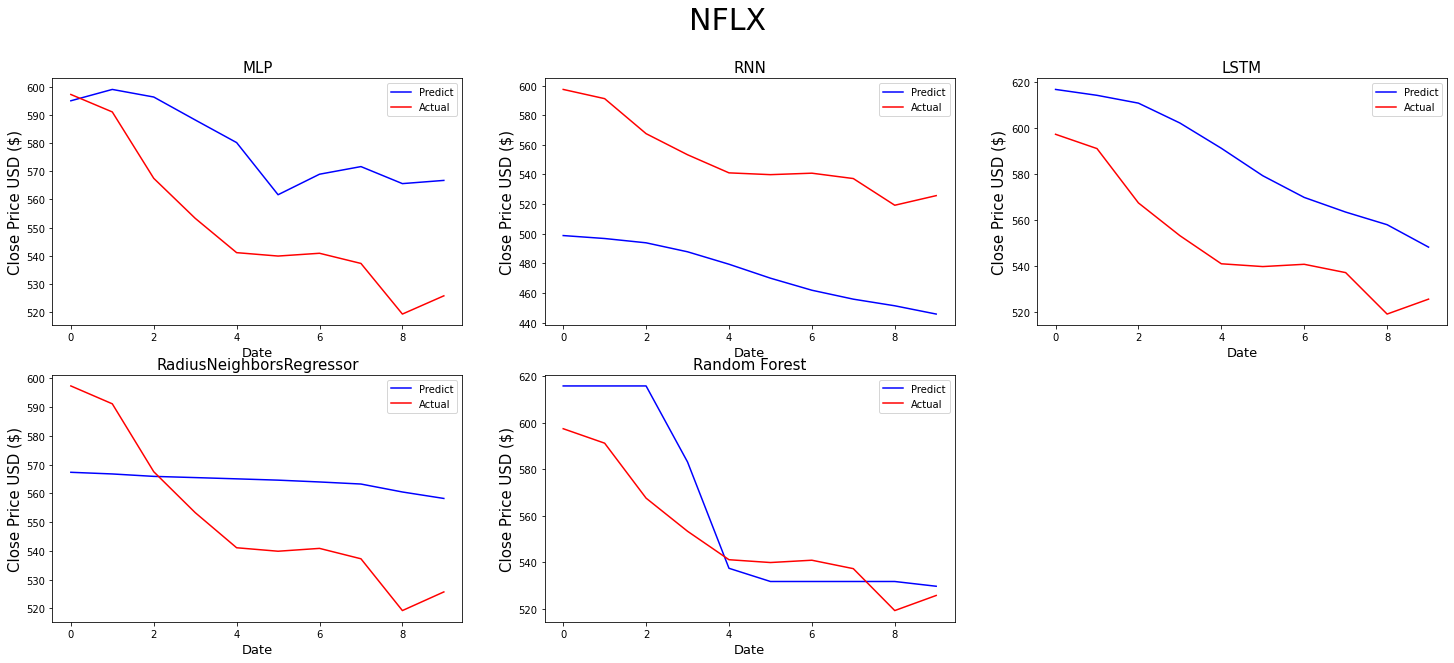

In [ ]:
#Visualize the test data
#Visualize the close price data
fg, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[1][2].set_visible(False)
fg.suptitle('NFLX\n', fontsize = 30)


ax[0,0].set_title('MLP', fontsize=15)
ax[0,1].set_title('RNN', fontsize=15)
ax[1,0].set_title('RadiusNeighborsRegressor',fontsize=15)
ax[1,1].set_title('Random Forest', fontsize=15)
ax[0,2].set_title('LSTM', fontsize=15)


ax[0,0].set_xlabel('Date', fontsize=13)
ax[0,1].set_xlabel('Date', fontsize=13)
ax[1,0].set_xlabel('Date', fontsize=13)
ax[1,1].set_xlabel('Date', fontsize=13)
ax[0,2].set_xlabel('Date', fontsize=13)



ax[0,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,2].set_ylabel('Close Price USD ($)', fontsize=15)


ax[0,0].plot(df_temp_nflx_mlp['Predicted'].values, color="blue")
ax[0,0].plot(df_temp_nflx_mlp['Actual'].values, color="red")
ax[0,0].legend(['Predict', 'Actual'])

ax[0,1].plot(df_temp_nflx_rnn['Predicted'].values, color="blue")
ax[0,1].plot(df_temp_nflx_rnn['Actual'].values, color="red")
ax[0,1].legend(['Predict', 'Actual'])

ax[1,0].plot(df_temp_nflx_knn['Predicted'].values, color="blue")
ax[1,0].plot(df_temp_nflx_knn['Actual'].values, color="red")
ax[1,0].legend(['Predict', 'Actual'])

ax[1,1].plot(df_temp_nflx_rf['Predicted'].values, color="blue")
ax[1,1].plot(df_temp_nflx_rf['Actual'].values, color="red")
ax[1,1].legend(['Predict', 'Actual'])

ax[0,2].plot(df_temp_nflx_lstm['Predicted'].values, color="blue")
ax[0,2].plot(df_temp_nflx_lstm['Actual'].values, color="red")
ax[0,2].legend(['Predict', 'Actual'])

####Time predict

In [ ]:
print('MLP: ', time_mlp )
print('RNN: ',time_rnn)
print('Radius neighbors regressor: ', time_radius)
print('Random Forest: ', time_rf )
print('LSTM: ', time_lstm )

MLP:  0.0017161369323730469
RNN:  0.0845034122467041
Radius neighbors regressor:  0.010457754135131836
Random Forest:  0.02383255958557129
LSTM:  0.07967233657836914


####Visualize MAE

In [ ]:
mae = [MAE_MLP, MAE_rnn, MAE_radius, MAE_rf, MAE_lstm]
names = ['MLP', 'RNN', 'Radius', 'Random Forest', 'LSTM']

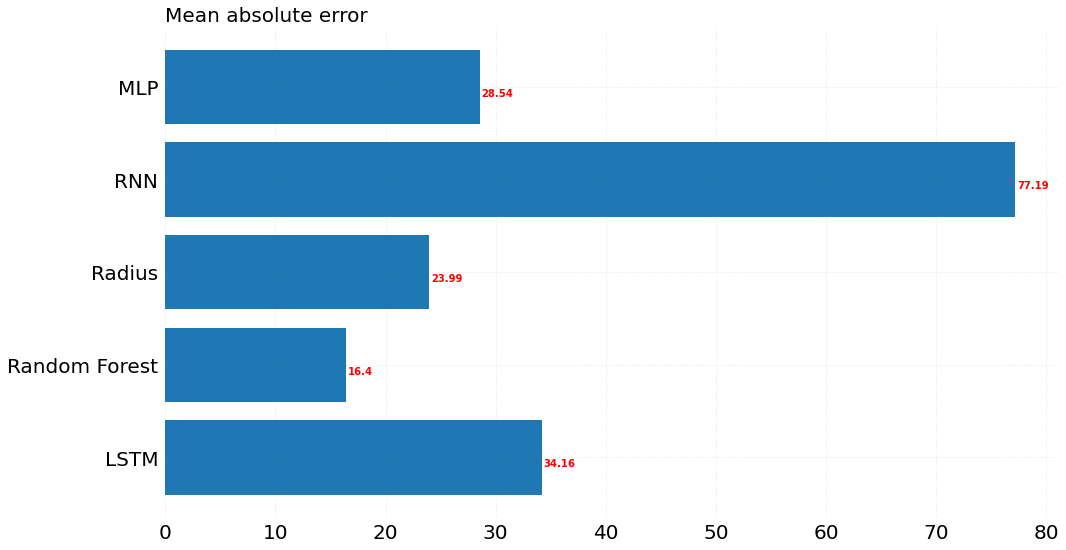

In [ ]:
# Figure Size
values = mae
fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(names, values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.tick_params(axis='both', which='major', labelsize=20)


# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='red')
# Add Plot Title
ax.set_title('Mean absolute error ',
             loc ='left',fontsize = '20' )
# Show Plot
plt.show()

#**Predict the 7 next weeks**

In [ ]:
#Load the test data
start_date_7w = '01-01-2022'
end_date_7w = '20-02-2022'
#co phieu chi thuc hien giao dich cac ngay trong tuan tru t7 chu nhat
test_data_7w_nflx = load_test(start_date_7w, end_date_7w, 'NFLX')

[*********************100%***********************]  1 of 1 completed


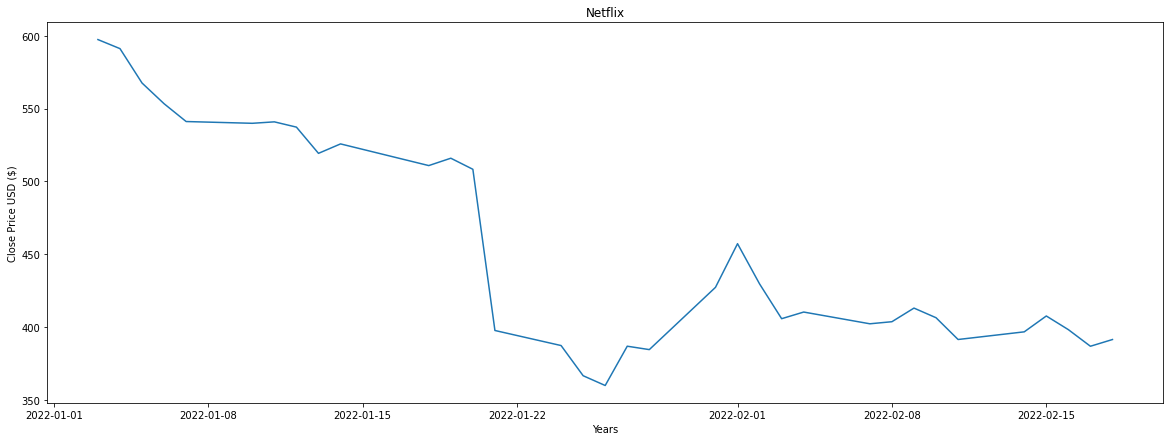

In [ ]:
#Visualize the test data
#Visualize the close price data
data = df_nflx.filter(['Close'])
plt.figure(figsize=(20,7))
plt.title('Netflix')
plt.xlabel('Years')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data_7w_nflx)
plt.show()


##Get data predict to predict close prices of the next day

In [ ]:
inputs_nflx = df_nflx['Close'][df_nflx['Close'].shape[0] - predict_days:].values.reshape(-1,1)
inputs_nflx= scaler1.transform(inputs_nflx)
#Prediction on test data
x_test_nflx_7w = np.array(inputs_nflx).reshape(1,-1)
print(x_test_nflx_7w.shape)

(1, 60)


####Recurrent Neural Network(RNN)

In [ ]:
print("start date",start_date_7w)
print("end date",end_date_7w)
start_time = time.time()
prices_nflx_rnn = predict_the_next_n_day(start_date_7w, end_date_7w, X_train_nflx, y_train_nflx, x_test_nflx_7w, regressor)
end_time = time.time()
time_predicted_rnn_7w_nflx = -start_time + end_time

start date 01-01-2022
end date 20-02-2022
02-01-2022 is Sunday
1/1 [==============================] - 0s 26ms/step
Predict day 2 :DONE
1/1 [==============================] - 0s 24ms/step
Predict day 3 :DONE
1/1 [==============================] - 0s 24ms/step
Predict day 4 :DONE
1/1 [==============================] - 0s 26ms/step
Predict day 5 :DONE
1/1 [==============================] - 0s 28ms/step
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
1/1 [==============================] - 0s 27ms/step
Predict day 9 :DONE
1/1 [==============================] - 0s 28ms/step
Predict day 10 :DONE
1/1 [==============================] - 0s 31ms/step
Predict day 11 :DONE
1/1 [==============================] - 0s 24ms/step
Predict day 12 :DONE
1/1 [==============================] - 0s 33ms/step
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday
17-01-2022 is holiday
1/1 [==============================] - 0s 28ms/step
Predict day 17 :DONE
1/1 [=========================

In [ ]:
prices_nflx_rnn = np.array(prices_nflx_rnn)
predicted_prices_nflx_rnn = scaler1.inverse_transform(prices_nflx_rnn.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_rnn = predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])
df_temp_nflx_rnn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rnn})
print(df_temp_nflx_rnn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  498.739441
2022-01-04  591.150024  485.607483
2022-01-05  567.520020  466.802032
2022-01-06  553.289978  444.399780
2022-01-07  541.059998  423.057037
2022-01-10  539.849976  403.824188
2022-01-11  540.840027  386.315338
2022-01-12  537.219971  369.790375
2022-01-13  519.200012  352.083221
2022-01-14  525.690002  335.577850
2022-01-18  510.799988  319.596283
2022-01-19  515.859985  304.677094
2022-01-20  508.250000  290.528351
2022-01-21  397.500000  277.716064
2022-01-24  387.149994  265.841522
2022-01-25  366.420013  255.021164
2022-01-26  359.700012  244.714706
2022-01-27  386.700012  235.473694
2022-01-28  384.359985  226.666260
2022-01-31  427.140015  218.379517
2022-02-01  457.130005  210.800781
2022-02-02  429.480011  203.672516
2022-02-03  405.600006  197.002441
2022-02-04  410.170013  190.632248
2022-02-07  402.100006  184.658188
2022-02-08  403.529999  178.982407
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_rnn = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_rnn)
print('Mean Absolute Error:', MAE_rnn)


Mean Absolute Error: 183.33679288976333


####MLP

In [ ]:
print("start date",start_date_7w)
print("end date",end_date_7w)
start_time = time.time()
prices_nflx_mlp = predict_the_next_n_day(start_date_7w, end_date_7w, X_train_nflx, y_train_nflx, x_test_nflx_7w, mlp_nflx)
end_time = time.time()
time_predicted_MLP_7w_nflx = -start_time + end_time

start date 01-01-2022
end date 20-02-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday
17-01-2022 is holiday
Predict day 17 :DONE
Predict day 18 :DONE
Predict day 19 :DONE
Predict day 20 :DONE
22-01-2022 is Saturday
23-01-2022 is Sunday
Predict day 23 :DONE
Predict day 24 :DONE
Predict day 25 :DONE
Predict day 26 :DONE
Predict day 27 :DONE
29-01-2022 is Saturday
30-01-2022 is Sunday
Predict day 30 :DONE
Predict day 31 :DONE
Predict day 32 :DONE
Predict day 33 :DONE
Predict day 34 :DONE
05-02-2022 is Saturday
06-02-2022 is Sunday
Predict day 37 :DONE
Predict day 38 :DONE
Predict day 39 :DONE
Predict day 40 :DONE
Predict day 41 :DONE
12-02-2022 is Saturday
13-02-2022 is Sunday
Predict day 44 :DONE
Predict day 45 :DONE
Predic

In [ ]:
prices_nflx_mlp = np.array(prices_nflx_mlp)
predicted_prices_nflx_mlp = scaler1.inverse_transform(prices_nflx_mlp.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_mlp= predicted_prices_nflx_mlp.reshape([(predicted_prices_nflx_mlp.shape[0])])
df_temp_nflx_mlp = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_mlp})
print(df_temp_nflx_mlp)

                Actual   Predicted
Date                              
2022-01-03  597.369995  595.124482
2022-01-04  591.150024  598.534216
2022-01-05  567.520020  597.980784
2022-01-06  553.289978  598.478645
2022-01-07  541.059998  597.884528
2022-01-10  539.849976  588.764517
2022-01-11  540.840027  602.674450
2022-01-12  537.219971  610.144654
2022-01-13  519.200012  609.315065
2022-01-14  525.690002  610.821354
2022-01-18  510.799988  605.680941
2022-01-19  515.859985  599.829952
2022-01-20  508.250000  609.256026
2022-01-21  397.500000  606.319102
2022-01-24  387.149994  595.705533
2022-01-25  366.420013  583.390950
2022-01-26  359.700012  564.596357
2022-01-27  386.700012  561.475606
2022-01-28  384.359985  578.555728
2022-01-31  427.140015  582.287857
2022-02-01  457.130005  591.721536
2022-02-02  429.480011  597.899397
2022-02-03  405.600006  597.012153
2022-02-04  410.170013  604.864189
2022-02-07  402.100006  596.409036
2022-02-08  403.529999  588.916550
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_mlp = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_mlp)
print('Mean Absolute Error:', MAE_mlp)


Mean Absolute Error: 132.31593237176534


####Radius neighbors regressor

In [ ]:
print("start date",start_date_7w)
print("end date",end_date_7w)
start_time = time.time()
prices_nflx_knn = predict_the_next_n_day(start_date_7w, end_date_7w, X_train_nflx, y_train_nflx, x_test_nflx_7w, neigh_nflx)
end_time = time.time()
time_predicted_radius_7w_nflx = -start_time + end_time

start date 01-01-2022
end date 20-02-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday
17-01-2022 is holiday
Predict day 17 :DONE
Predict day 18 :DONE
Predict day 19 :DONE
Predict day 20 :DONE
22-01-2022 is Saturday
23-01-2022 is Sunday
Predict day 23 :DONE
Predict day 24 :DONE
Predict day 25 :DONE
Predict day 26 :DONE
Predict day 27 :DONE
29-01-2022 is Saturday
30-01-2022 is Sunday
Predict day 30 :DONE
Predict day 31 :DONE
Predict day 32 :DONE
Predict day 33 :DONE
Predict day 34 :DONE
05-02-2022 is Saturday
06-02-2022 is Sunday
Predict day 37 :DONE
Predict day 38 :DONE
Predict day 39 :DONE
Predict day 40 :DONE
Predict day 41 :DONE
12-02-2022 is Saturday
13-02-2022 is Sunday
Predict day 44 :DONE
Predict day 45 :DONE
Predic

In [ ]:
prices_nflx_knn = np.array(prices_nflx_knn)
predicted_prices_nflx_knn = scaler1.inverse_transform(prices_nflx_knn.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_knn = predicted_prices_nflx_knn.reshape([(predicted_prices_nflx_knn.shape[0])])
df_temp_nflx_knn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_knn})
print(df_temp_nflx_knn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  567.318865
2022-01-04  591.150024  566.259847
2022-01-05  567.520020  565.662573
2022-01-06  553.289978  565.193950
2022-01-07  541.059998  564.890240
2022-01-10  539.849976  564.467904
2022-01-11  540.840027  563.954600
2022-01-12  537.219971  563.233132
2022-01-13  519.200012  560.318716
2022-01-14  525.690002  559.363469
2022-01-18  510.799988  557.293638
2022-01-19  515.859985  552.564211
2022-01-20  508.250000  550.492314
2022-01-21  397.500000  548.000884
2022-01-24  387.149994  547.064298
2022-01-25  366.420013  546.499318
2022-01-26  359.700012  545.849048
2022-01-27  386.700012  545.508048
2022-01-28  384.359985  545.297567
2022-01-31  427.140015  544.911177
2022-02-01  457.130005  544.776475
2022-02-02  429.480011  544.663092
2022-02-03  405.600006  544.663092
2022-02-04  410.170013  544.577424
2022-02-07  402.100006  544.521223
2022-02-08  403.529999  544.545981
2022-02-09  412.8900

####Mean absolute error

In [ ]:
MAE_radius = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_knn)
print('Mean Absolute Error:', MAE_radius)

Mean Absolute Error: 100.04685984818798


####Random Forest

In [ ]:
print("start date",start_date_7w)
print("end date",end_date_7w)
start_time = time.time()
prices_nflx_rf = predict_the_next_n_day(start_date_7w, end_date_7w, X_train_nflx, y_train_nflx, x_test_nflx_7w, regr_nflx)
end_time = time.time()
time_predicted_RF_7w_nflx = -start_time + end_time

start date 01-01-2022
end date 20-02-2022
02-01-2022 is Sunday
Predict day 2 :DONE
Predict day 3 :DONE
Predict day 4 :DONE
Predict day 5 :DONE
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
Predict day 9 :DONE
Predict day 10 :DONE
Predict day 11 :DONE
Predict day 12 :DONE
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday
17-01-2022 is holiday
Predict day 17 :DONE
Predict day 18 :DONE
Predict day 19 :DONE
Predict day 20 :DONE
22-01-2022 is Saturday
23-01-2022 is Sunday
Predict day 23 :DONE
Predict day 24 :DONE
Predict day 25 :DONE
Predict day 26 :DONE
Predict day 27 :DONE
29-01-2022 is Saturday
30-01-2022 is Sunday
Predict day 30 :DONE
Predict day 31 :DONE
Predict day 32 :DONE
Predict day 33 :DONE
Predict day 34 :DONE
05-02-2022 is Saturday
06-02-2022 is Sunday
Predict day 37 :DONE
Predict day 38 :DONE
Predict day 39 :DONE
Predict day 40 :DONE
Predict day 41 :DONE
12-02-2022 is Saturday
13-02-2022 is Sunday
Predict day 44 :DONE
Predict day 45 :DONE
Predic

In [ ]:
prices_nflx_rf = np.array(prices_nflx_rf)
predicted_prices_nflx_rf = scaler1.inverse_transform(prices_nflx_rf.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_rf= predicted_prices_nflx_rf.reshape([(predicted_prices_nflx_rf.shape[0])])
df_temp_nflx_rf = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rf})
print(df_temp_nflx_rf)

                Actual   Predicted
Date                              
2022-01-03  597.369995  615.752611
2022-01-04  591.150024  615.752611
2022-01-05  567.520020  615.752611
2022-01-06  553.289978  615.752611
2022-01-07  541.059998  615.752611
2022-01-10  539.849976  615.752611
2022-01-11  540.840027  615.752611
2022-01-12  537.219971  615.752611
2022-01-13  519.200012  615.752611
2022-01-14  525.690002  615.752611
2022-01-18  510.799988  615.752611
2022-01-19  515.859985  615.752611
2022-01-20  508.250000  615.752611
2022-01-21  397.500000  615.752611
2022-01-24  387.149994  615.752611
2022-01-25  366.420013  615.752611
2022-01-26  359.700012  615.752611
2022-01-27  386.700012  615.752611
2022-01-28  384.359985  615.752611
2022-01-31  427.140015  615.752611
2022-02-01  457.130005  615.752611
2022-02-02  429.480011  615.752611
2022-02-03  405.600006  615.752611
2022-02-04  410.170013  615.752611
2022-02-07  402.100006  615.752611
2022-02-08  403.529999  615.752611
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_rf = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_rf)
print('Mean Absolute Error:', MAE_rf)

Mean Absolute Error: 161.17555077935697


####Long short term memory

In [ ]:
print("start date",start_date_7w)
print("end date",end_date_7w)
start_time = time.time()
prices_nflx_lstm = predict_the_next_n_day(start_date_7w, end_date_7w, X_train_nflx, y_train_nflx, x_test_nflx_7w,model)
end_time = time.time()
time_predicted_lstm_7w_nflx = -start_time + end_time

start date 01-01-2022
end date 20-02-2022
02-01-2022 is Sunday
1/1 [==============================] - 0s 30ms/step
Predict day 2 :DONE
1/1 [==============================] - 0s 31ms/step
Predict day 3 :DONE
1/1 [==============================] - 0s 31ms/step
Predict day 4 :DONE
1/1 [==============================] - 0s 32ms/step
Predict day 5 :DONE
1/1 [==============================] - 0s 33ms/step
Predict day 6 :DONE
08-01-2022 is Saturday
09-01-2022 is Sunday
1/1 [==============================] - 0s 37ms/step
Predict day 9 :DONE
1/1 [==============================] - 0s 34ms/step
Predict day 10 :DONE
1/1 [==============================] - 0s 30ms/step
Predict day 11 :DONE
1/1 [==============================] - 0s 35ms/step
Predict day 12 :DONE
1/1 [==============================] - 0s 27ms/step
Predict day 13 :DONE
15-01-2022 is Saturday
16-01-2022 is Sunday
17-01-2022 is holiday
1/1 [==============================] - 0s 35ms/step
Predict day 17 :DONE
1/1 [=========================

In [ ]:
prices_nflx_lstm = np.array(prices_nflx_lstm)
predicted_prices_nflx_lstm = scaler1.inverse_transform(prices_nflx_lstm.reshape(-1,1))

In [ ]:
actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_lstm= predicted_prices_nflx_lstm.reshape([(predicted_prices_nflx_lstm.shape[0])])
df_temp_nflx_lstm = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_lstm})
print(df_temp_nflx_lstm)

                Actual   Predicted
Date                              
2022-01-03  597.369995  616.875183
2022-01-04  591.150024  618.984802
2022-01-05  567.520020  621.407776
2022-01-06  553.289978  623.529663
2022-01-07  541.059998  625.485596
2022-01-10  539.849976  627.493042
2022-01-11  540.840027  629.621948
2022-01-12  537.219971  631.764099
2022-01-13  519.200012  633.854065
2022-01-14  525.690002  635.871460
2022-01-18  510.799988  637.828491
2022-01-19  515.859985  639.730042
2022-01-20  508.250000  641.575745
2022-01-21  397.500000  643.363403
2022-01-24  387.149994  645.093384
2022-01-25  366.420013  646.766052
2022-01-26  359.700012  648.381470
2022-01-27  386.700012  649.938293
2022-01-28  384.359985  651.434631
2022-01-31  427.140015  652.869690
2022-02-01  457.130005  654.242493
2022-02-02  429.480011  655.552734
2022-02-03  405.600006  656.800598
2022-02-04  410.170013  657.987122
2022-02-07  402.100006  659.113220
2022-02-08  403.529999  660.180237
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_lstm = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_lstm)
print('Mean Absolute Error:', MAE_lstm)

Mean Absolute Error: 191.86494894588694


####Visualize real prices and predicted prices

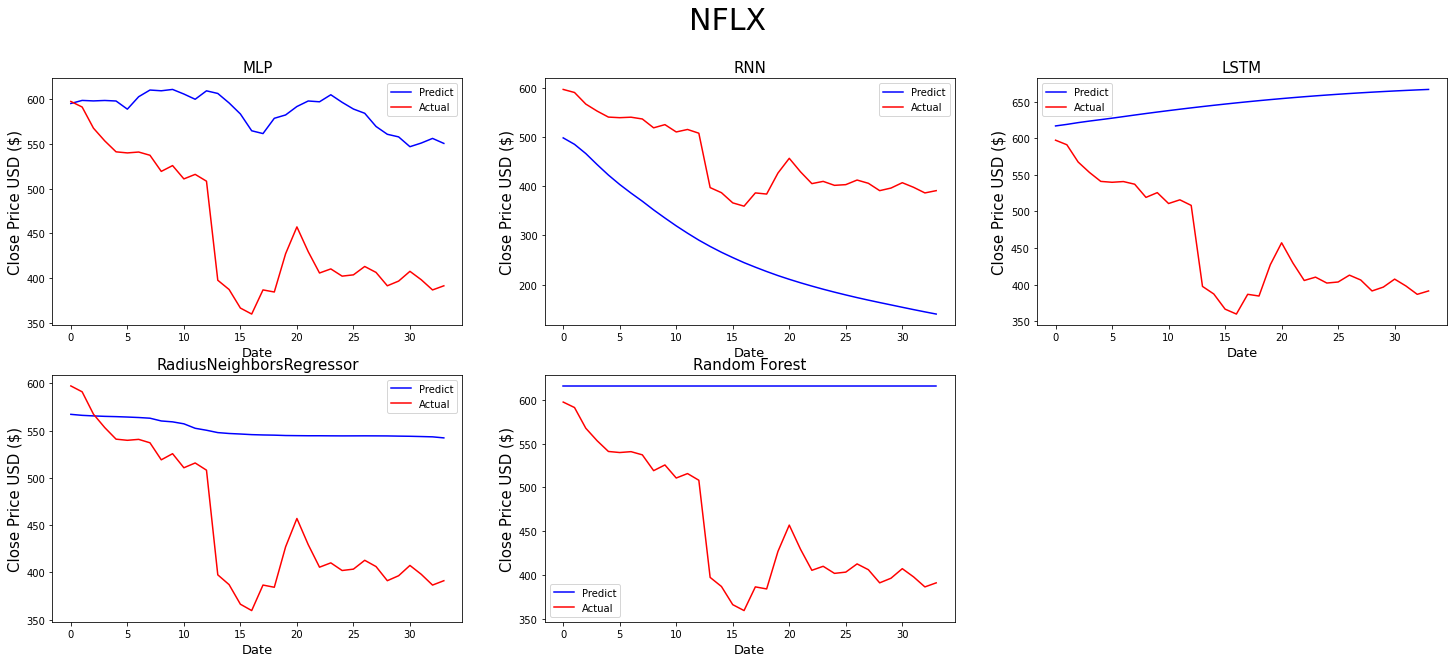

In [ ]:
#Visualize the test data
#Visualize the close price data
fg, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[1][2].set_visible(False)
fg.suptitle('NFLX\n', fontsize = 30)


ax[0,0].set_title('MLP', fontsize=15)
ax[0,1].set_title('RNN', fontsize=15)
ax[1,0].set_title('RadiusNeighborsRegressor',fontsize=15)
ax[1,1].set_title('Random Forest', fontsize=15)
ax[0,2].set_title('LSTM', fontsize=15)


ax[0,0].set_xlabel('Date', fontsize=13)
ax[0,1].set_xlabel('Date', fontsize=13)
ax[1,0].set_xlabel('Date', fontsize=13)
ax[1,1].set_xlabel('Date', fontsize=13)
ax[0,2].set_xlabel('Date', fontsize=13)



ax[0,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,2].set_ylabel('Close Price USD ($)', fontsize=15)


ax[0,0].plot(df_temp_nflx_mlp['Predicted'].values, color="blue")
ax[0,0].plot(df_temp_nflx_mlp['Actual'].values, color="red")
ax[0,0].legend(['Predict', 'Actual'])

ax[0,1].plot(df_temp_nflx_rnn['Predicted'].values, color="blue")
ax[0,1].plot(df_temp_nflx_rnn['Actual'].values, color="red")
ax[0,1].legend(['Predict', 'Actual'])

ax[1,0].plot(df_temp_nflx_knn['Predicted'].values, color="blue")
ax[1,0].plot(df_temp_nflx_knn['Actual'].values, color="red")
ax[1,0].legend(['Predict', 'Actual'])

ax[1,1].plot(df_temp_nflx_rf['Predicted'].values, color="blue")
ax[1,1].plot(df_temp_nflx_rf['Actual'].values, color="red")
ax[1,1].legend(['Predict', 'Actual'])

ax[0,2].plot(df_temp_nflx_lstm['Predicted'].values, color="blue")
ax[0,2].plot(df_temp_nflx_lstm['Actual'].values, color="red")
ax[0,2].legend(['Predict', 'Actual'])

####Visualize MAE

In [ ]:
mae = [MAE_mlp, MAE_rnn, MAE_radius, MAE_rf, MAE_lstm]
names = ['MLP', 'RNN', 'Radius', 'Random Forest', 'LSTM']

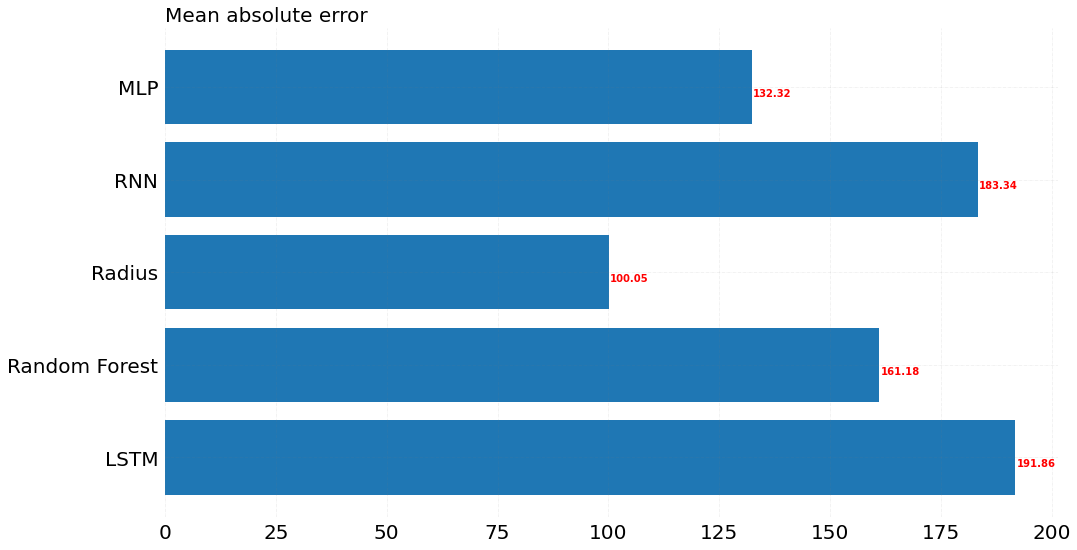

In [ ]:
# Figure Size
values = mae
fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(names, values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.tick_params(axis='both', which='major', labelsize=20)


# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='red')
# Add Plot Title
ax.set_title('Mean absolute error ',
             loc ='left',fontsize = '20' )
# Show Plot
plt.show()

####Time predict

In [ ]:
print('MLP: ', time_predicted_MLP_7w_nflx)
print('RNN: ',time_predicted_rnn_7w_nflx)
print('Radius neighbors regressor: ',time_predicted_radius_7w_nflx)
print('Random Forest: ',time_predicted_RF_7w_nflx )
print('LSTM: ',time_predicted_lstm_7w_nflx )

MLP:  0.09027481079101562
RNN:  2.4196741580963135
Radius neighbors regressor:  0.22448468208312988
Random Forest:  0.4674842357635498
LSTM:  2.6921417713165283


##Get the real data to predict close prices of the next day

In [ ]:
total_dataset_nflx = pd.concat((df_nflx['Close'],test_data_7w_nflx), axis = 0)
inputs_nflx_7w = total_dataset_nflx[len(total_dataset_nflx) - len(test_data_7w_nflx) - 60:].values.reshape(-1,1)
inputs_nflx_7w = scaler1.transform(inputs_nflx_7w)

#Prediction on test data
x_test_nflx_7w = []
for x in range(60, len(inputs_nflx_7w)):
  x_test_nflx_7w.append(inputs_nflx_7w[x-60:x, 0])
x_test_nflx_7w = np.array(x_test_nflx_7w)



####Recurrent Neural Network(RNN)

In [ ]:
start = time.time()
predicted_prices_nflx_rnn = regressor.predict(x_test_nflx_7w).reshape(-1,1)
end = time.time()
time_rnn = end - start
predicted_prices_nflx_rnn = scaler1.inverse_transform(predicted_prices_nflx_rnn)

2/2 [==============================] - 0s 18ms/step


In [ ]:

actual_prices_nflx = test_data_7w_nflx

predicted_prices_nflx_rnn = predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])


df_temp_nflx_rnn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rnn})
print(df_temp_nflx_rnn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  498.739380
2022-01-04  591.150024  496.749542
2022-01-05  567.520020  493.847870
2022-01-06  553.289978  487.788391
2022-01-07  541.059998  479.392151
2022-01-10  539.849976  469.978485
2022-01-11  540.840027  461.845367
2022-01-12  537.219971  455.817230
2022-01-13  519.200012  451.344360
2022-01-14  525.690002  445.759125
2022-01-18  510.799988  440.972382
2022-01-19  515.859985  435.309235
2022-01-20  508.250000  430.718018
2022-01-21  397.500000  426.644592
2022-01-24  387.149994  411.226929
2022-01-25  366.420013  391.816315
2022-01-26  359.700012  370.206024
2022-01-27  386.700012  351.417664
2022-01-28  384.359985  341.585571
2022-01-31  427.140015  335.736542
2022-02-01  457.130005  339.897888
2022-02-02  429.480011  348.403625
2022-02-03  405.600006  351.364746
2022-02-04  410.170013  349.421265
2022-02-07  402.100006  343.879059
2022-02-08  403.529999  338.033691
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_rnn = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_rnn)
print('Mean Absolute Error:', MAE_rnn)

Mean Absolute Error: 66.08486399931066


####MLP

In [ ]:
start = time.time()
predicted_prices_nflx_mlp = mlp_nflx.predict(x_test_nflx_7w).reshape(-1,1)
end = time.time()
time_mlp = end - start
predicted_prices_nflx_mlp = scaler1.inverse_transform(predicted_prices_nflx_mlp)

In [ ]:

actual_prices_nflx = test_data_7w_nflx
predicted_prices_nflx_mlp= predicted_prices_nflx_mlp.reshape([(predicted_prices_nflx_mlp.shape[0])])

df_temp_nflx_mlp = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_mlp})
print(df_temp_nflx_mlp)

                Actual   Predicted
Date                              
2022-01-03  597.369995  595.124482
2022-01-04  591.150024  599.163373
2022-01-05  567.520020  596.461985
2022-01-06  553.289978  588.298830
2022-01-07  541.059998  580.239003
2022-01-10  539.849976  561.677101
2022-01-11  540.840027  568.982360
2022-01-12  537.219971  571.695698
2022-01-13  519.200012  565.636060
2022-01-14  525.690002  566.778001
2022-01-18  510.799988  561.942426
2022-01-19  515.859985  548.455687
2022-01-20  508.250000  548.417424
2022-01-21  397.500000  541.676779
2022-01-24  387.149994  508.394426
2022-01-25  366.420013  471.104954
2022-01-26  359.700012  442.938016
2022-01-27  386.700012  425.656301
2022-01-28  384.359985  432.897382
2022-01-31  427.140015  445.032336
2022-02-01  457.130005  474.087925
2022-02-02  429.480011  485.797422
2022-02-03  405.600006  466.877169
2022-02-04  410.170013  470.704003
2022-02-07  402.100006  436.338623
2022-02-08  403.529999  431.142671
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_mlp = metrics.mean_absolute_error(actual_prices_nflx,predicted_prices_nflx_mlp)
print('Mean Absolute Error:', MAE_mlp)

Mean Absolute Error: 41.62185456410124


####Radius Neighbor Regressor

In [ ]:
print(x_test_nflx_7w.shape)
start = time.time()
predicted_prices_nflx_knn = neigh_nflx.predict(x_test_nflx_7w).reshape(-1,1)
end = time.time()
time_radius = end - start
print(predicted_prices_nflx_knn.shape)
predicted_prices_nflx_knn = scaler1.inverse_transform(predicted_prices_nflx_knn)
predicted_prices_nflx_knn = predicted_prices_nflx_knn.reshape([(predicted_prices_nflx_knn.shape[0])])


(34, 60)
(34, 1)


In [ ]:
df_temp_nflx_knn= pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_knn})
print(df_temp_nflx_knn)

                Actual   Predicted
Date                              
2022-01-03  597.369995  567.318865
2022-01-04  591.150024  566.741938
2022-01-05  567.520020  565.897749
2022-01-06  553.289978  565.478078
2022-01-07  541.059998  565.040290
2022-01-10  539.849976  564.587606
2022-01-11  540.840027  563.954600
2022-01-12  537.219971  563.233132
2022-01-13  519.200012  560.466694
2022-01-14  525.690002  558.217305
2022-01-18  510.799988  554.635306
2022-01-19  515.859985  551.654781
2022-01-20  508.250000  548.936631
2022-01-21  397.500000  546.980768
2022-01-24  387.149994  546.696031
2022-01-25  366.420013  546.528385
2022-01-26  359.700012  546.265313
2022-01-27  386.700012  546.007436
2022-01-28  384.359985  545.776315
2022-01-31  427.140015  545.508048
2022-02-01  457.130005  545.508048
2022-02-02  429.480011  545.508048
2022-02-03  405.600006  544.823680
2022-02-04  410.170013  539.071056
2022-02-07  402.100006  534.838542
2022-02-08  403.529999  532.430840
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_radius = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_knn)
print('Mean Absolute Error:', MAE_radius)

Mean Absolute Error: 95.17751390629186


####Random Forest

In [ ]:
start = time.time()
predicted_prices_nflx_rf = regr_nflx.predict(x_test_nflx_7w).reshape(-1,1)
end = time.time()
time_rf = end - start
predicted_prices_nflx_rf = scaler1.inverse_transform(predicted_prices_nflx_rf)
predicted_prices_nflx_rf = predicted_prices_nflx_rf.reshape([(predicted_prices_nflx_rf.shape[0])])

In [ ]:
df_temp_nflx_rf= pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rf})
print(df_temp_nflx_rf)

                Actual   Predicted
Date                              
2022-01-03  597.369995  615.752611
2022-01-04  591.150024  615.752611
2022-01-05  567.520020  615.752611
2022-01-06  553.289978  583.073053
2022-01-07  541.059998  537.375017
2022-01-10  539.849976  531.698796
2022-01-11  540.840027  531.698796
2022-01-12  537.219971  531.698796
2022-01-13  519.200012  531.698796
2022-01-14  525.690002  529.651984
2022-01-18  510.799988  531.698796
2022-01-19  515.859985  515.638314
2022-01-20  508.250000  518.216839
2022-01-21  397.500000  512.095481
2022-01-24  387.149994  421.381358
2022-01-25  366.420013  390.690110
2022-01-26  359.700012  358.640969
2022-01-27  386.700012  358.640969
2022-01-28  384.359985  385.366532
2022-01-31  427.140015  381.882934
2022-02-01  457.130005  411.793176
2022-02-02  429.480011  483.171717
2022-02-03  405.600006  423.033809
2022-02-04  410.170013  415.464303
2022-02-07  402.100006  415.464303
2022-02-08  403.529999  415.464303
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_rf = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_rf)
print('Mean Absolute Error:', MAE_rf)


Mean Absolute Error: 20.575797015426307


####Long short term memory

In [ ]:
start = time.time()
predicted_prices_nflx_lstm = model.predict(x_test_nflx_7w).reshape(-1,1)
end = time.time()
time_lstm = end - start
predicted_prices_nflx_lstm = scaler1.inverse_transform(predicted_prices_nflx_lstm)
predicted_prices_nflx_lstm = predicted_prices_nflx_lstm.reshape([(predicted_prices_nflx_lstm.shape[0])])

2/2 [==============================] - 0s 37ms/step


In [ ]:
df_temp_nflx_lstm = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_lstm})
print(df_temp_nflx_lstm)

                Actual   Predicted
Date                              
2022-01-03  597.369995  616.875244
2022-01-04  591.150024  614.315063
2022-01-05  567.520020  610.912354
2022-01-06  553.289978  602.276917
2022-01-07  541.059998  591.285278
2022-01-10  539.849976  579.348633
2022-01-11  540.840027  569.915222
2022-01-12  537.219971  563.541565
2022-01-13  519.200012  558.056335
2022-01-14  525.690002  548.303711
2022-01-18  510.799988  542.628052
2022-01-19  515.859985  534.877380
2022-01-20  508.250000  530.991211
2022-01-21  397.500000  526.410645
2022-01-24  387.149994  488.454010
2022-01-25  366.420013  448.749481
2022-01-26  359.700012  412.706635
2022-01-27  386.700012  389.150055
2022-01-28  384.359985  390.186829
2022-01-31  427.140015  403.737946
2022-02-01  457.130005  430.884705
2022-02-02  429.480011  460.151184
2022-02-03  405.600006  460.828217
2022-02-04  410.170013  443.076782
2022-02-07  402.100006  425.790741
2022-02-08  403.529999  412.439423
2022-02-09  412.8900

#####Mean absolute error

In [ ]:
MAE_lstm = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_lstm)
print('Mean Absolute Error:', MAE_lstm)


Mean Absolute Error: 31.53978863884421


####Visualize real prices and predicted prices

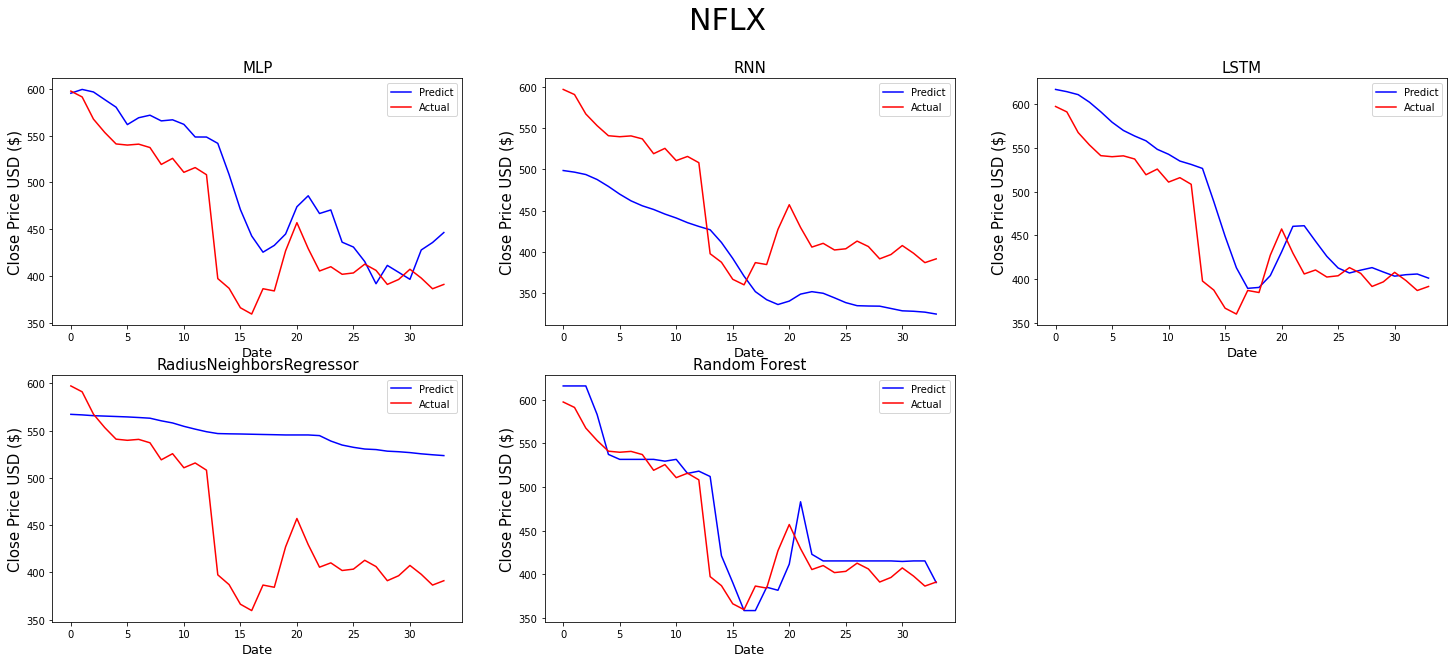

In [ ]:
#Visualize the test data
#Visualize the close price data
fg, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[1][2].set_visible(False)
fg.suptitle('NFLX\n', fontsize = 30)


ax[0,0].set_title('MLP', fontsize=15)
ax[0,1].set_title('RNN', fontsize=15)
ax[1,0].set_title('RadiusNeighborsRegressor',fontsize=15)
ax[1,1].set_title('Random Forest', fontsize=15)
ax[0,2].set_title('LSTM', fontsize=15)


ax[0,0].set_xlabel('Date', fontsize=13)
ax[0,1].set_xlabel('Date', fontsize=13)
ax[1,0].set_xlabel('Date', fontsize=13)
ax[1,1].set_xlabel('Date', fontsize=13)
ax[0,2].set_xlabel('Date', fontsize=13)



ax[0,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,0].set_ylabel('Close Price USD ($)', fontsize=15)
ax[1,1].set_ylabel('Close Price USD ($)', fontsize=15)
ax[0,2].set_ylabel('Close Price USD ($)', fontsize=15)


ax[0,0].plot(df_temp_nflx_mlp['Predicted'].values, color="blue")
ax[0,0].plot(df_temp_nflx_mlp['Actual'].values, color="red")
ax[0,0].legend(['Predict', 'Actual'])

ax[0,1].plot(df_temp_nflx_rnn['Predicted'].values, color="blue")
ax[0,1].plot(df_temp_nflx_rnn['Actual'].values, color="red")
ax[0,1].legend(['Predict', 'Actual'])

ax[1,0].plot(df_temp_nflx_knn['Predicted'].values, color="blue")
ax[1,0].plot(df_temp_nflx_knn['Actual'].values, color="red")
ax[1,0].legend(['Predict', 'Actual'])

ax[1,1].plot(df_temp_nflx_rf['Predicted'].values, color="blue")
ax[1,1].plot(df_temp_nflx_rf['Actual'].values, color="red")
ax[1,1].legend(['Predict', 'Actual'])

ax[0,2].plot(df_temp_nflx_lstm['Predicted'].values, color="blue")
ax[0,2].plot(df_temp_nflx_lstm['Actual'].values, color="red")
ax[0,2].legend(['Predict', 'Actual'])

####Time predict

In [ ]:
print('MLP: ', time_mlp)
print('RNN: ',time_lstm)
print('Radius neighbors regressor: ',time_radius)
print('Random Forest: ',time_rf )
print('LSTM: ',time_lstm )

MLP:  0.0037992000579833984
RNN:  0.33759474754333496
Radius neighbors regressor:  0.02144908905029297
Random Forest:  0.022767066955566406
LSTM:  0.33759474754333496


####Visualize MAE

In [ ]:
mae = [MAE_mlp, MAE_rnn, MAE_radius, MAE_rf, MAE_lstm]
names = ['MLP', 'RNN', 'Radius', 'Random Forest', 'LSTM']

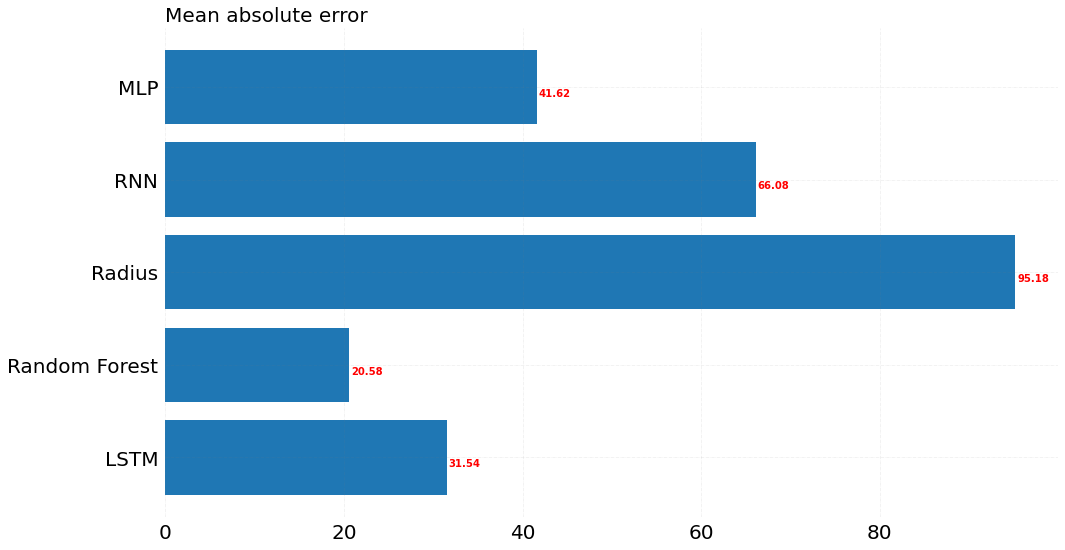

In [ ]:
# Figure Size
values = mae
fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(names, values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.tick_params(axis='both', which='major', labelsize=20)


# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='red')
# Add Plot Title
ax.set_title('Mean absolute error ',
             loc ='left',fontsize = '20' )
# Show Plot
plt.show()

#Xử lý Overfitting

##MLP

###Alpha = 1.0

In [ ]:
mlp_nflx = MLPRegressor(random_state=1,max_iter=1000,activation = 'relu',
                       solver = 'adam', alpha = 1.0)
#fit model
mlp_nflx.fit(X_train_nflx,y_train_nflx)
predicted_prices_nflx_mlp_notOver = mlp_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_mlp_not_Over = scaler1.inverse_transform(predicted_prices_nflx_mlp_notOver)

###Alpha = 0

In [ ]:
#regression model NFLX
mlp_nflx = MLPRegressor(random_state=1,max_iter=1000,activation = 'relu',
                       solver = 'adam', alpha = 0.0)
#fit model
mlp_nflx.fit(X_train_nflx,y_train_nflx)

MLPRegressor(alpha=0.0, max_iter=1000, random_state=1)

In [ ]:
predicted_prices_nflx_mlp = mlp_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_mlp = scaler1.inverse_transform(predicted_prices_nflx_mlp)

In [ ]:
actual_prices_nflx =  close_prices_nflx[60:]
predicted_prices_nflx_mlp = predicted_prices_nflx_mlp.reshape([(predicted_prices_nflx_mlp.shape[0])])
df_temp_nflx_mlp = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_mlp})
print(df_temp_nflx_mlp)

          Actual   Predicted
0       4.910000    4.553396
1       4.874286    4.739491
2       5.051429    4.900102
3       5.025714    4.896530
4       5.100000    5.041919
...          ...         ...
4467  613.119995  621.859738
4468  610.710022  627.891554
4469  610.539978  621.001285
4470  612.090027  606.803488
4471  602.440002  615.302280

[4472 rows x 2 columns]


In [ ]:
MAE_mlp = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_mlp)
print('Mean Absolute Error:', MAE_mlp)

Mean Absolute Error: 4.8595505614415115


###Visualize

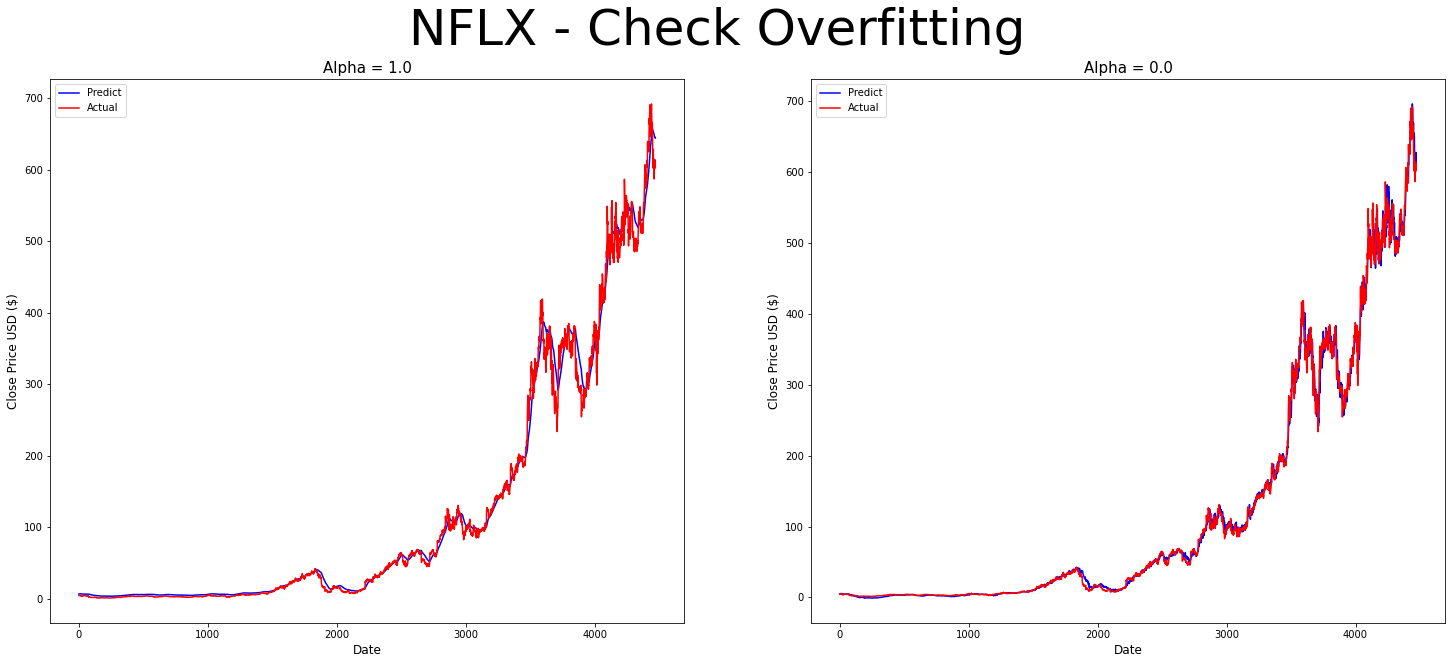

In [ ]:

#Visualize the close price data

fg, ax = plt.subplots(1, 2, figsize=(25, 10))

fg.suptitle('NFLX - Check Overfitting \n', fontsize = 50)


ax[0].set_title('Alpha = 1.0', fontsize = 15)
ax[1].set_title('Alpha = 0.0', fontsize = 15)


ax[0].set_xlabel('Date', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)


ax[0].set_ylabel('Close Price USD ($)', fontsize=12)
ax[1].set_ylabel('Close Price USD ($)', fontsize=12)


ax[0].plot(predicted_prices_nflx_mlp_not_Over, color="blue")
ax[0].plot(actual_prices_nflx, color="red")
ax[0].legend(['Predict', 'Actual'])

ax[1].plot(predicted_prices_nflx_mlp , color="blue")
ax[1].plot(actual_prices_nflx, color="red")
ax[1].legend(['Predict', 'Actual'])


##RNN

### Dropout = 0.2

In [ ]:
predicted_prices_nflx_rnn = regressor.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_rnn = scaler1.inverse_transform(predicted_prices_nflx_rnn)
predicted_prices_nflx_rnn_notOver = predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])
actual_prices_nflx = close_prices_nflx[60:]

140/140 [==============================] - 2s 15ms/step


###Dropout(0.0)

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Add the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True, input_shape = (X_train_nflx.shape[1], 1)))


# Second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True))

# Third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "relu", return_sequences = True))


# Fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))

# Add the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

# Fitting the RNN to the training set
regressor.fit(X_train_nflx, y_train_nflx, epochs = 50, batch_size = 32)


Epoch 1/50
140/140 [==============================] - 13s 65ms/step - loss: 9.6743e-04
Epoch 2/50
140/140 [==============================] - 8s 55ms/step - loss: 2.0604e-04
Epoch 3/50
140/140 [==============================] - 8s 56ms/step - loss: 1.7437e-04
Epoch 4/50
140/140 [==============================] - 8s 54ms/step - loss: 1.3119e-04
Epoch 5/50
140/140 [==============================] - 8s 54ms/step - loss: 1.1318e-04
Epoch 6/50
140/140 [==============================] - 8s 60ms/step - loss: 1.3877e-04
Epoch 7/50
140/140 [==============================] - 8s 59ms/step - loss: 1.2554e-04
Epoch 8/50
140/140 [==============================] - 11s 78ms/step - loss: 1.0993e-04
Epoch 9/50
140/140 [==============================] - 8s 55ms/step - loss: 8.4339e-05
Epoch 10/50
140/140 [==============================] - 12s 83ms/step - loss: 1.3196e-04
Epoch 11/50
140/140 [==============================] - 8s 54ms/step - loss: 8.9180e-05
Epoch 12/50
140/140 [============================

In [ ]:
predicted_prices_nflx_rnn = regressor.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_rnn = scaler1.inverse_transform(predicted_prices_nflx_rnn)

140/140 [==============================] - 3s 16ms/step


In [ ]:
actual_prices_nflx =  close_prices_nflx[60:]
predicted_prices_nflx_rnn = predicted_prices_nflx_rnn.reshape([(predicted_prices_nflx_rnn.shape[0])])
df_temp_nflx_rnn = pd.DataFrame({'Actual': actual_prices_nflx, 'Predicted': predicted_prices_nflx_rnn})
print(df_temp_nflx_rnn)

          Actual   Predicted
0       4.910000    4.809480
1       4.874286    5.135219
2       5.051429    5.247019
3       5.025714    5.197242
4       5.100000    5.234195
...          ...         ...
4467  613.119995  607.709473
4468  610.710022  603.280884
4469  610.539978  603.968750
4470  612.090027  600.439758
4471  602.440002  605.788269

[4472 rows x 2 columns]


In [ ]:
MAE_rnn = metrics.mean_absolute_error(actual_prices_nflx, predicted_prices_nflx_rnn)
print('Mean Absolute Error:', MAE_rnn)

Mean Absolute Error: 2.833594203635064


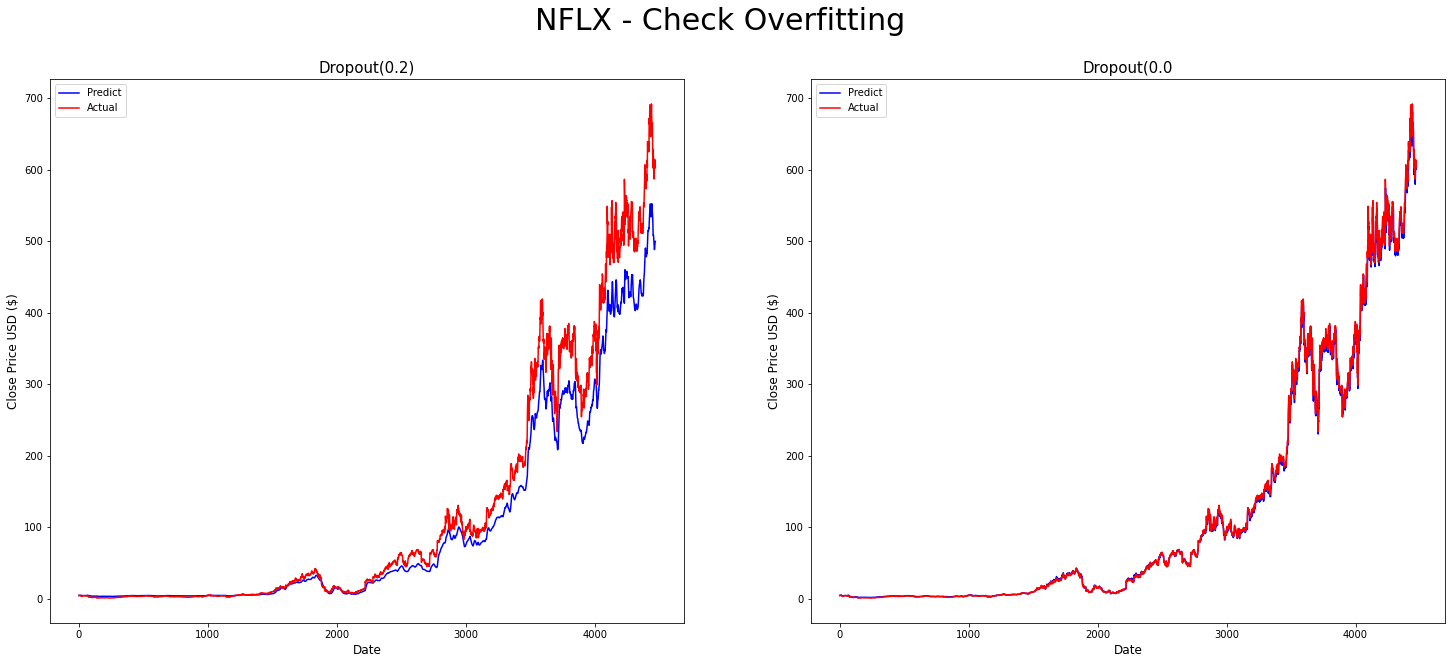

In [ ]:
#Visualize the test data
#Visualize the close price data

fg, ax = plt.subplots(1, 2, figsize=(25, 10))

fg.suptitle('NFLX - Check Overfitting \n', fontsize = 30)


ax[0].set_title('Dropout(0.2)', fontsize = 15)
ax[1].set_title('Dropout(0.0',  fontsize = 15)


ax[0].set_xlabel('Date', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)


ax[0].set_ylabel('Close Price USD ($)', fontsize=12)
ax[1].set_ylabel('Close Price USD ($)', fontsize=12)


ax[0].plot(predicted_prices_nflx_rnn_notOver, color="blue")
ax[0].plot(actual_prices_nflx, color="red")
ax[0].legend(['Predict', 'Actual'])

ax[1].plot(predicted_prices_nflx_rnn , color="blue")
ax[1].plot(actual_prices_nflx, color="red")
ax[1].legend(['Predict', 'Actual'])

##Radius neighbors regressor

###Radius = 1.5

In [ ]:
predicted_prices_nflx_radius = neigh_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_radius_notOver = scaler1.inverse_transform(predicted_prices_nflx_radius)

###Radius = 0.1

In [ ]:
neigh_nflx = RadiusNeighborsRegressor(radius=0.1)
neigh_nflx.fit(X_train_nflx, y_train_nflx)

RadiusNeighborsRegressor(radius=0.1)

In [ ]:
predicted_prices_nflx_radius = neigh_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_radius = scaler1.inverse_transform(predicted_prices_nflx_radius)
predicted_prices_nflx_radius= predicted_prices_nflx_radius.reshape([(predicted_prices_nflx_radius.shape[0])])
actual_prices_nflx = close_prices_nflx[60:]

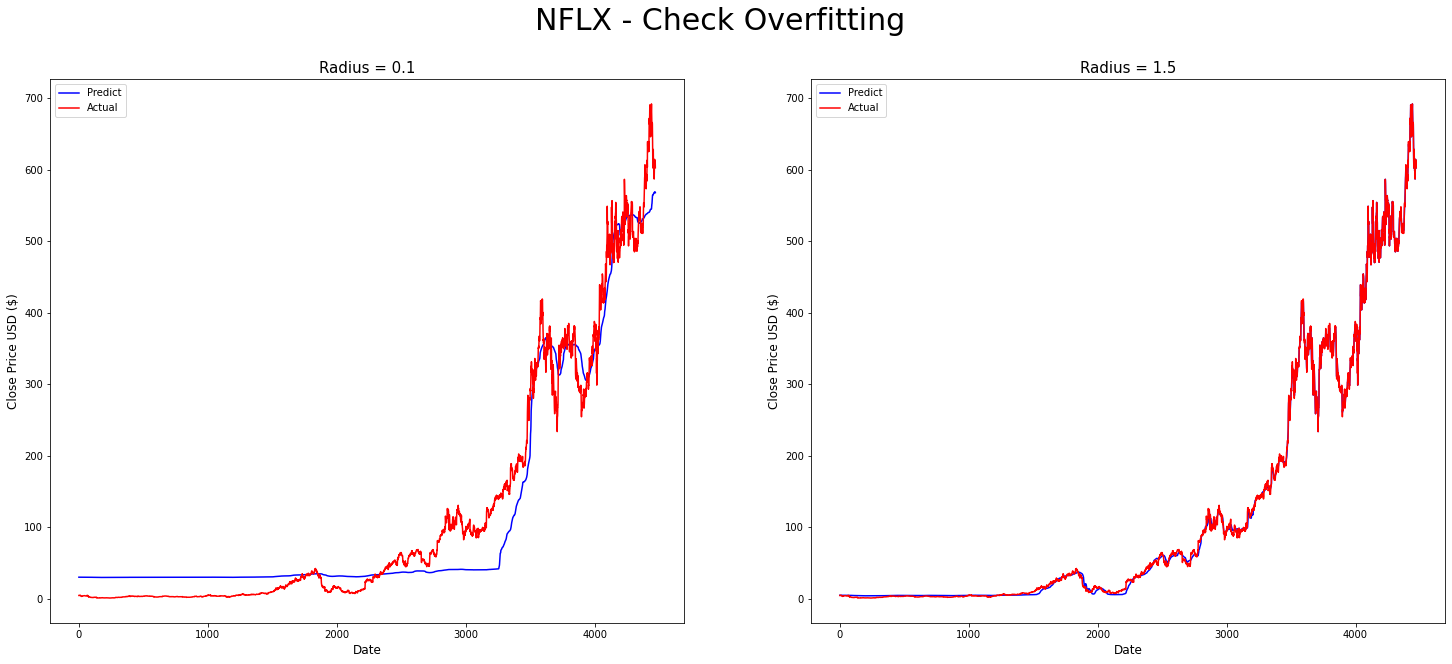

In [ ]:
#Visualize the test data
#Visualize the close price data

fg, ax = plt.subplots(1, 2, figsize=(25, 10))

fg.suptitle('NFLX - Check Overfitting \n', fontsize = 30)


ax[0].set_title('Radius = 0.1', fontsize= 15)
ax[1].set_title('Radius = 1.5',  fontsize= 15)


ax[0].set_xlabel('Date', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)


ax[0].set_ylabel('Close Price USD ($)', fontsize=12)
ax[1].set_ylabel('Close Price USD ($)', fontsize=12)


ax[0].plot(predicted_prices_nflx_radius_notOver, color="blue")
ax[0].plot(actual_prices_nflx, color="red")
ax[0].legend(['Predict', 'Actual'])


ax[1].plot(predicted_prices_nflx_radius , color="blue")
ax[1].plot(actual_prices_nflx, color="red")
ax[1].legend(['Predict', 'Actual'])


##Random Forest

###max_depth=4, max_leaf_nodes=13

In [ ]:
predicted_prices_nflx_rf = regr_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_rf_notOver = scaler1.inverse_transform(predicted_prices_nflx_rf)

###max_depth=10

In [ ]:
regr_nflx = RandomForestRegressor(max_depth=10, random_state=0)
regr_nflx.fit(X_train_nflx, y_train_nflx)

RandomForestRegressor(max_depth=10, random_state=0)

In [ ]:
predicted_prices_nflx_rf = regr_nflx.predict(X_train_nflx).reshape(-1,1)
predicted_prices_nflx_rf = scaler1.inverse_transform(predicted_prices_nflx_rf)
predicted_prices_nflx_rf = predicted_prices_nflx_rf.reshape([(predicted_prices_nflx_rf.shape[0])])
actual_prices_nflx = close_prices_nflx[60:]

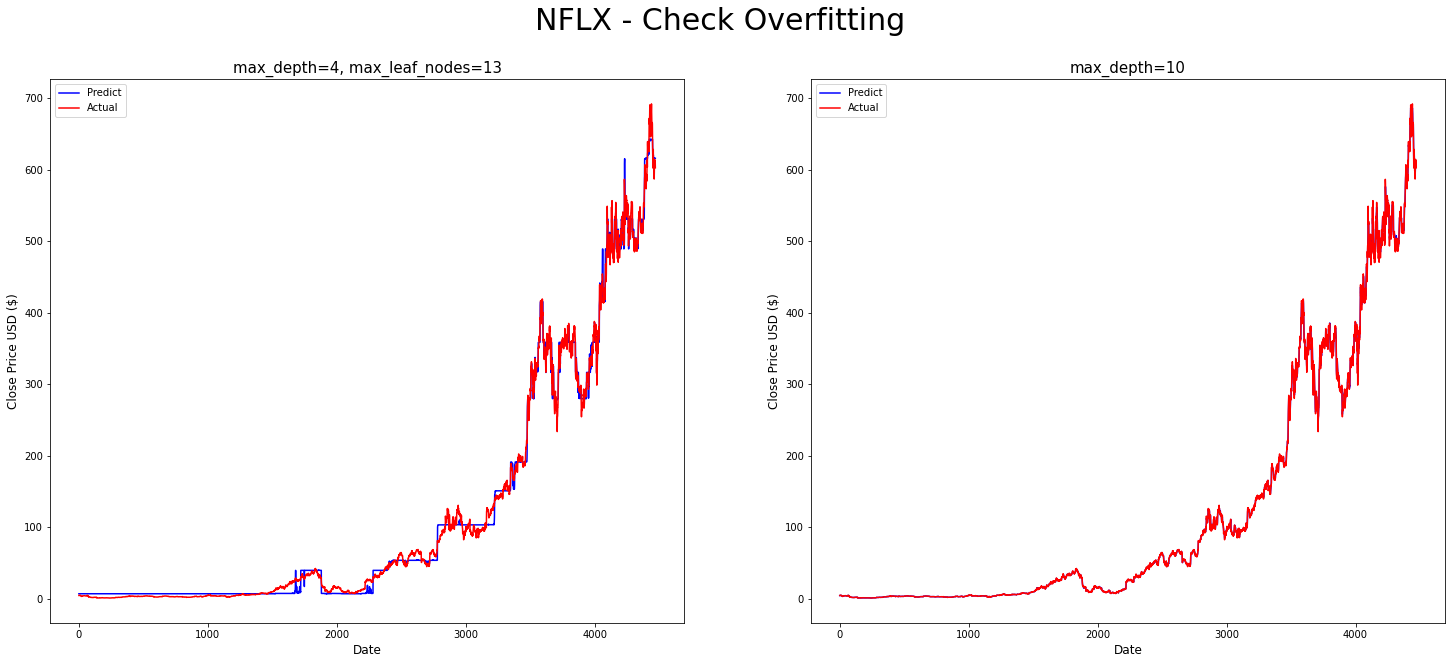

In [ ]:
#Visualize the test data
#Visualize the close price data

fg, ax = plt.subplots(1, 2, figsize=(25, 10))

fg.suptitle('NFLX - Check Overfitting \n', fontsize = 30)


ax[0].set_title('max_depth=4, max_leaf_nodes=13', fontsize = 15)
ax[1].set_title('max_depth=10', fontsize = 15)


ax[0].set_xlabel('Date', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)


ax[0].set_ylabel('Close Price USD ($)', fontsize=12)
ax[1].set_ylabel('Close Price USD ($)', fontsize=12)


ax[0].plot(predicted_prices_nflx_rf_notOver, color="blue")
ax[0].plot(actual_prices_nflx, color="red")
ax[0].legend(['Predict', 'Actual'])


ax[1].plot(predicted_prices_nflx_rf , color="blue")
ax[1].plot(actual_prices_nflx, color="red")
ax[1].legend(['Predict', 'Actual'])


# Tìm feature nào ảnh hưởng nhất đến output

Ta sẽ dùng Random Forest để tìm được feature ảnh hưởng nhất đến giá Close

In [ ]:
df_nflx.round(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,4.11,4.13,3.84,3.92,3.92,50230600
2004-01-05,3.89,4.06,3.88,3.99,3.99,25207000
2004-01-06,3.95,4.34,3.94,4.26,4.26,52633000
2004-01-07,4.31,4.47,4.25,4.45,4.45,68432000
2004-01-08,4.54,4.56,4.29,4.43,4.43,37178400
...,...,...,...,...,...,...
2021-12-27,615.00,615.00,609.25,613.12,613.12,2061500
2021-12-28,614.95,618.41,609.69,610.71,610.71,1882800
2021-12-29,610.71,613.98,604.68,610.54,610.54,1287200


In [ ]:
X_train = df_nflx.loc[:,'Open':'Close']
y_train= df_nflx.loc[:,'Close'].values
y_train.shape

(4532,)

In [ ]:
print(X_train)

                  Open        High         Low       Close
Date                                                      
2004-01-02    4.107143    4.127857    3.842143    3.916429
2004-01-05    3.892857    4.061429    3.875000    3.992857
2004-01-06    3.946429    4.339286    3.937143    4.257857
2004-01-07    4.307143    4.470000    4.249286    4.445714
2004-01-08    4.539286    4.564286    4.291429    4.432857
...                ...         ...         ...         ...
2021-12-27  615.000000  615.000000  609.250000  613.119995
2021-12-28  614.950012  618.409973  609.690002  610.710022
2021-12-29  610.710022  613.979980  604.679993  610.539978
2021-12-30  612.989990  620.609985  611.239990  612.090027
2021-12-31  610.010010  614.080017  602.049988  602.440002

[4532 rows x 4 columns]


In [ ]:
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
X_scaled2_nflx = scaler2.fit_transform(X_train.values)
y_scaled3_nflx = scaler3.fit_transform(y_train.reshape(-1,1))

Create data train

In [ ]:
X,Y = [],[]
predict_days = 60
for i in range(predict_days,len(y_train)):
  X.append(X_scaled2_nflx[i-predict_days:i,:])
  Y.append(y_scaled3_nflx[i,0])
X, y = np.array(X), np.array(Y)

In [ ]:
X.shape

(4472, 60, 4)

In [ ]:
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

In [ ]:
X.shape

(4472, 240)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

RandomForestRegressor()

In [ ]:
importances = rf_model.feature_importances_

In [ ]:
sum1 = 0
sum2 = 0
sum3 = 0
sum4 =0
for i in range(len(importances)):
  if i < 60:
    sum1 += importances[i]
  elif i >= 60 and i < 60*2:
    sum2 += importances[i]
  elif i >= 60*2 and i < 60*3:
    sum3 += importances[i]
  else:
    sum4 +=  importances[i]

feature = [sum1,sum2,sum3, sum4]
indices = np.argsort(feature)
indices

array([1, 2, 0, 3])

In [ ]:
a = list(zip(X_train.columns,indices))
a

[('Open', 1), ('High', 2), ('Low', 0), ('Close', 3)]

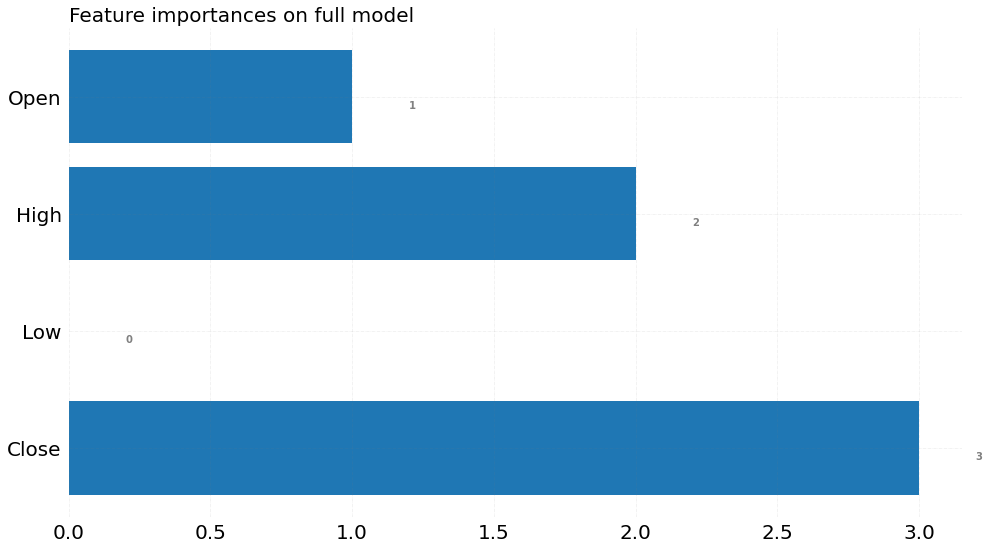

In [ ]:
# Figure Size
names = X_train.columns
values = indices
fig, ax = plt.subplots(figsize =(16, 9))
# Horizontal Bar Plot
ax.barh(names, values)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.tick_params(axis='both', which='major', labelsize=20)
# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
# Add Plot Title
ax.set_title('Feature importances on full model',
             loc ='left',fontsize = '20' )
# Show Plot
plt.show()